# Glass Identification Analysis

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import Callback, EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from tqdm import tqdm
from tensorflow.keras import layers, regularizers
import hashlib
from sklearn.metrics import accuracy_score

from scipy.stats import skew
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
model_results = {}

## I) Data cleaning

### Dataframe

In [3]:
columns = [
    "Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"
]

glass_df = pd.read_csv("../data/GlassIdentification.data", names=columns, header=None)


# Drop the Id column
glass_df.drop("Id", axis=1, inplace=True)

print(glass_df.head())

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1


In [4]:
glass_df.describe()

RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        Type  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1.000000  
25%      8.240000    0.000000    0.000000    1.000000  
50%      8.600000    0.000000    0.000000    2.000000  
75%      9.172500    0.000000    0.100000    3.000000  
max     16.190000    3.150000    0.510000    7.000000

### Labels

In [6]:
index_to_label = {
    1: "building_float",
    2: "building_nfloat",
    3: "vehicle_float",
    4: "vehicle_nfloat",
    5: "containers",
    6: "tableware",
    7: "headlamps"
}

### Missing values

In [7]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


**Comments**
- No null values so there is no need to handle missing values or NaN values.

### Duplicate rows

In [8]:
# Check duplicate rows
glass_df.duplicated().sum()
glass_df[glass_df.duplicated(keep=False)]

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
38  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1
39  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1

In [9]:
# Remove duplicate rows
glass_df = glass_df.drop_duplicates()

In [10]:
# Check after remove duplicate rows
glass_df.duplicated().sum()

0

## II) Data analysis

### Basic Descriptive Statistic


#### 1. Glass Type Distribution
- Class 1 (Building Windows – Float): 70 samples
- Class 2 (Building Windows – Non-Float): 76 samples
- Class 3 (Vehicle Windows – Float): 17 samples
- Class 4 (Vehicle Windows – Non-Float): 0 samples
- Class 5 (Containers): 13 samples
- Class 6 (Tableware): 9 samples
- Class 7 (Headlamps): 29 samples
- Note: Class 4 is absent in the dataset.

#### 2. Descriptive Statistics Highlights
| Feature              | Mean   | Std Dev | Min   | Max   | Notes                  |
|----------------------|--------|---------|-------|-------|------------------------|
| RI (Refractive Index)| 1.518  | 0.003   | 1.511 | 1.534 | Low variation          |
| Na (Sodium)          | 13.41  | 0.82    | 10.73 | 17.38 | Moderate spread        |
| Mg (Magnesium)       | 2.68   | 1.44    | 0.00  | 4.49  | Some zero values       |
| Al (Aluminum)        | 1.44   | 0.50    | 0.29  | 3.50  | Moderate spread        |
| Si (Silicon)         | 72.65  | 0.77    | 69.81 | 75.41 | Narrow range           |
| K (Potassium)        | 0.50   | 0.65    | 0.00  | 6.21  | Skewed, many zeros     |
| Ca (Calcium)         | 8.96   | 1.42    | 5.43  | 16.19 | Wide variation         |
| Ba (Barium)          | 0.18   | 0.50    | 0.00  | 3.15  | Mostly zero            |
| Fe (Iron)            | 0.057  | 0.097   | 0.00  | 0.51  | Mostly zero     

### Class distribution

C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1392051352.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_distribution, x="Label", y="Count", palette="crest")


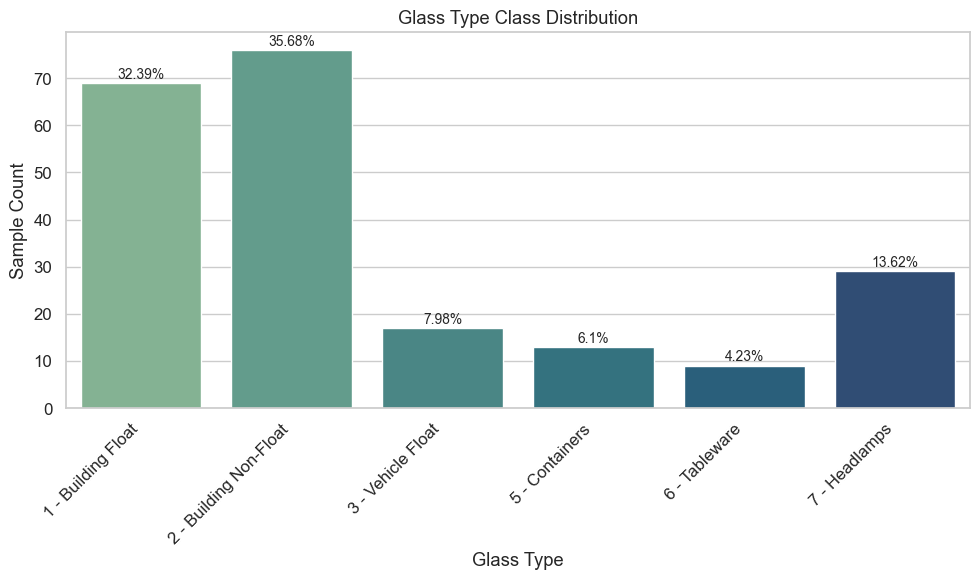

In [11]:
# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

# Class distribution
# Define full label mapping
label_map = {
    1: "1 - Building Float",
    2: "2 - Building Non-Float",
    3: "3 - Vehicle Float",
    4: "4 - Vehicle Non-Float (None)",
    5: "5 - Containers",
    6: "6 - Tableware",
    7: "7 - Headlamps"
}

# Create class distribution table using only existing classes
class_counts = glass_df['Type'].value_counts().sort_index()
class_percent = (class_counts / len(glass_df) * 100).round(2)

class_distribution = pd.DataFrame({
    "Class": class_counts.index,
    "Count": class_counts.values,
    "Percentage": class_percent.values
})

# Map class label names
class_distribution["Label"] = class_distribution["Class"].map(label_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution, x="Label", y="Count", palette="crest")
plt.xticks(rotation=45, ha='right')
plt.title("Glass Type Class Distribution")
plt.ylabel("Sample Count")
plt.xlabel("Glass Type")
for i, row in class_distribution.iterrows():
    plt.text(i, row["Count"] + 1, f"{row['Percentage']}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

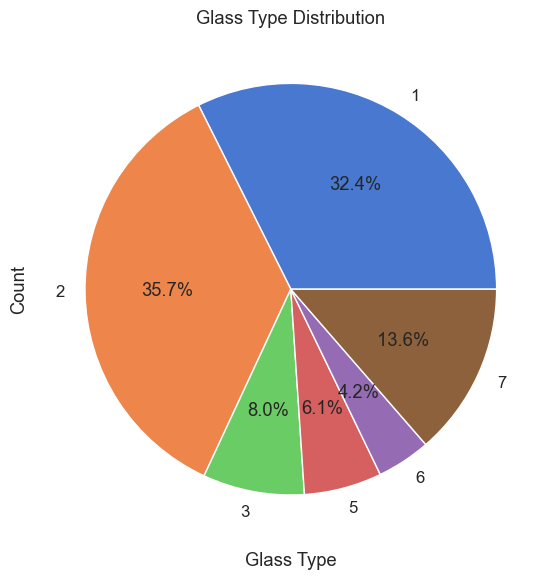

In [12]:
counts = glass_df['Type'].value_counts().sort_index()

plt.figure(figsize=(10,6))
counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Glass Type Distribution')
plt.xlabel('Glass Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Comments**
- The dataset is imbalanced, with Class 1 and Class 2 being the most frequent.
- Classes 3, 5, 6, and 7 have fewer samples, which may lead to challenges in classification tasks.

### Class correlation

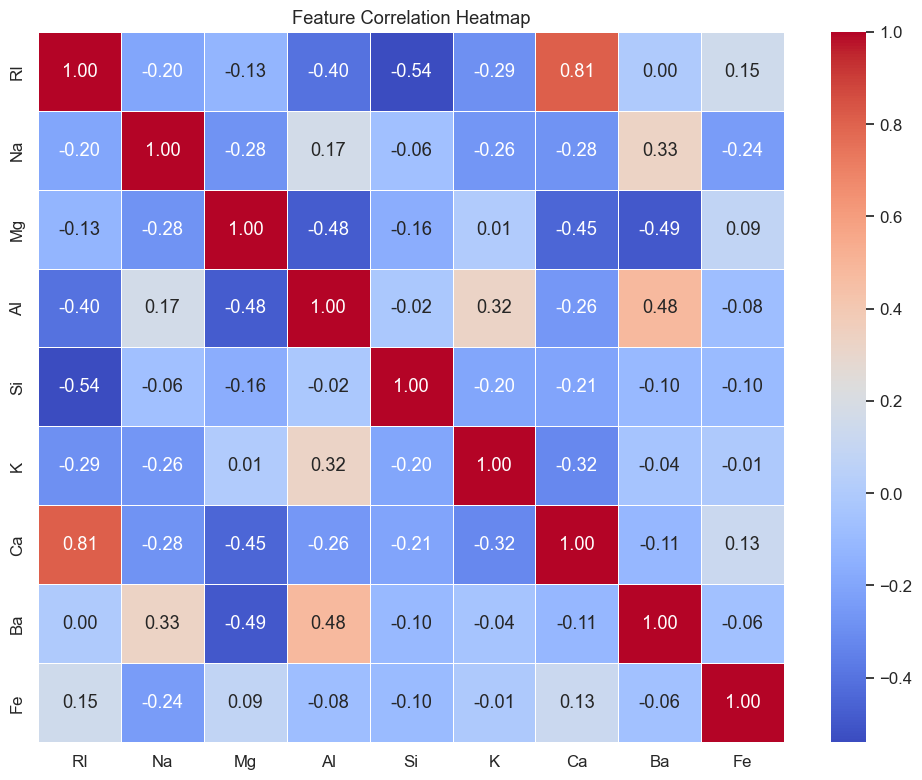

In [13]:
# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
# ----- 2. Correlation Heatmap -----
corr_matrix = glass_df.drop(columns='Type').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

**Comments**
- There are some cell has high correlation between variables, which may lead to muticolinearity.
- We may consider use PCA to detect outliers and reduce the multicolinear effects later in the project.

### Pair plot

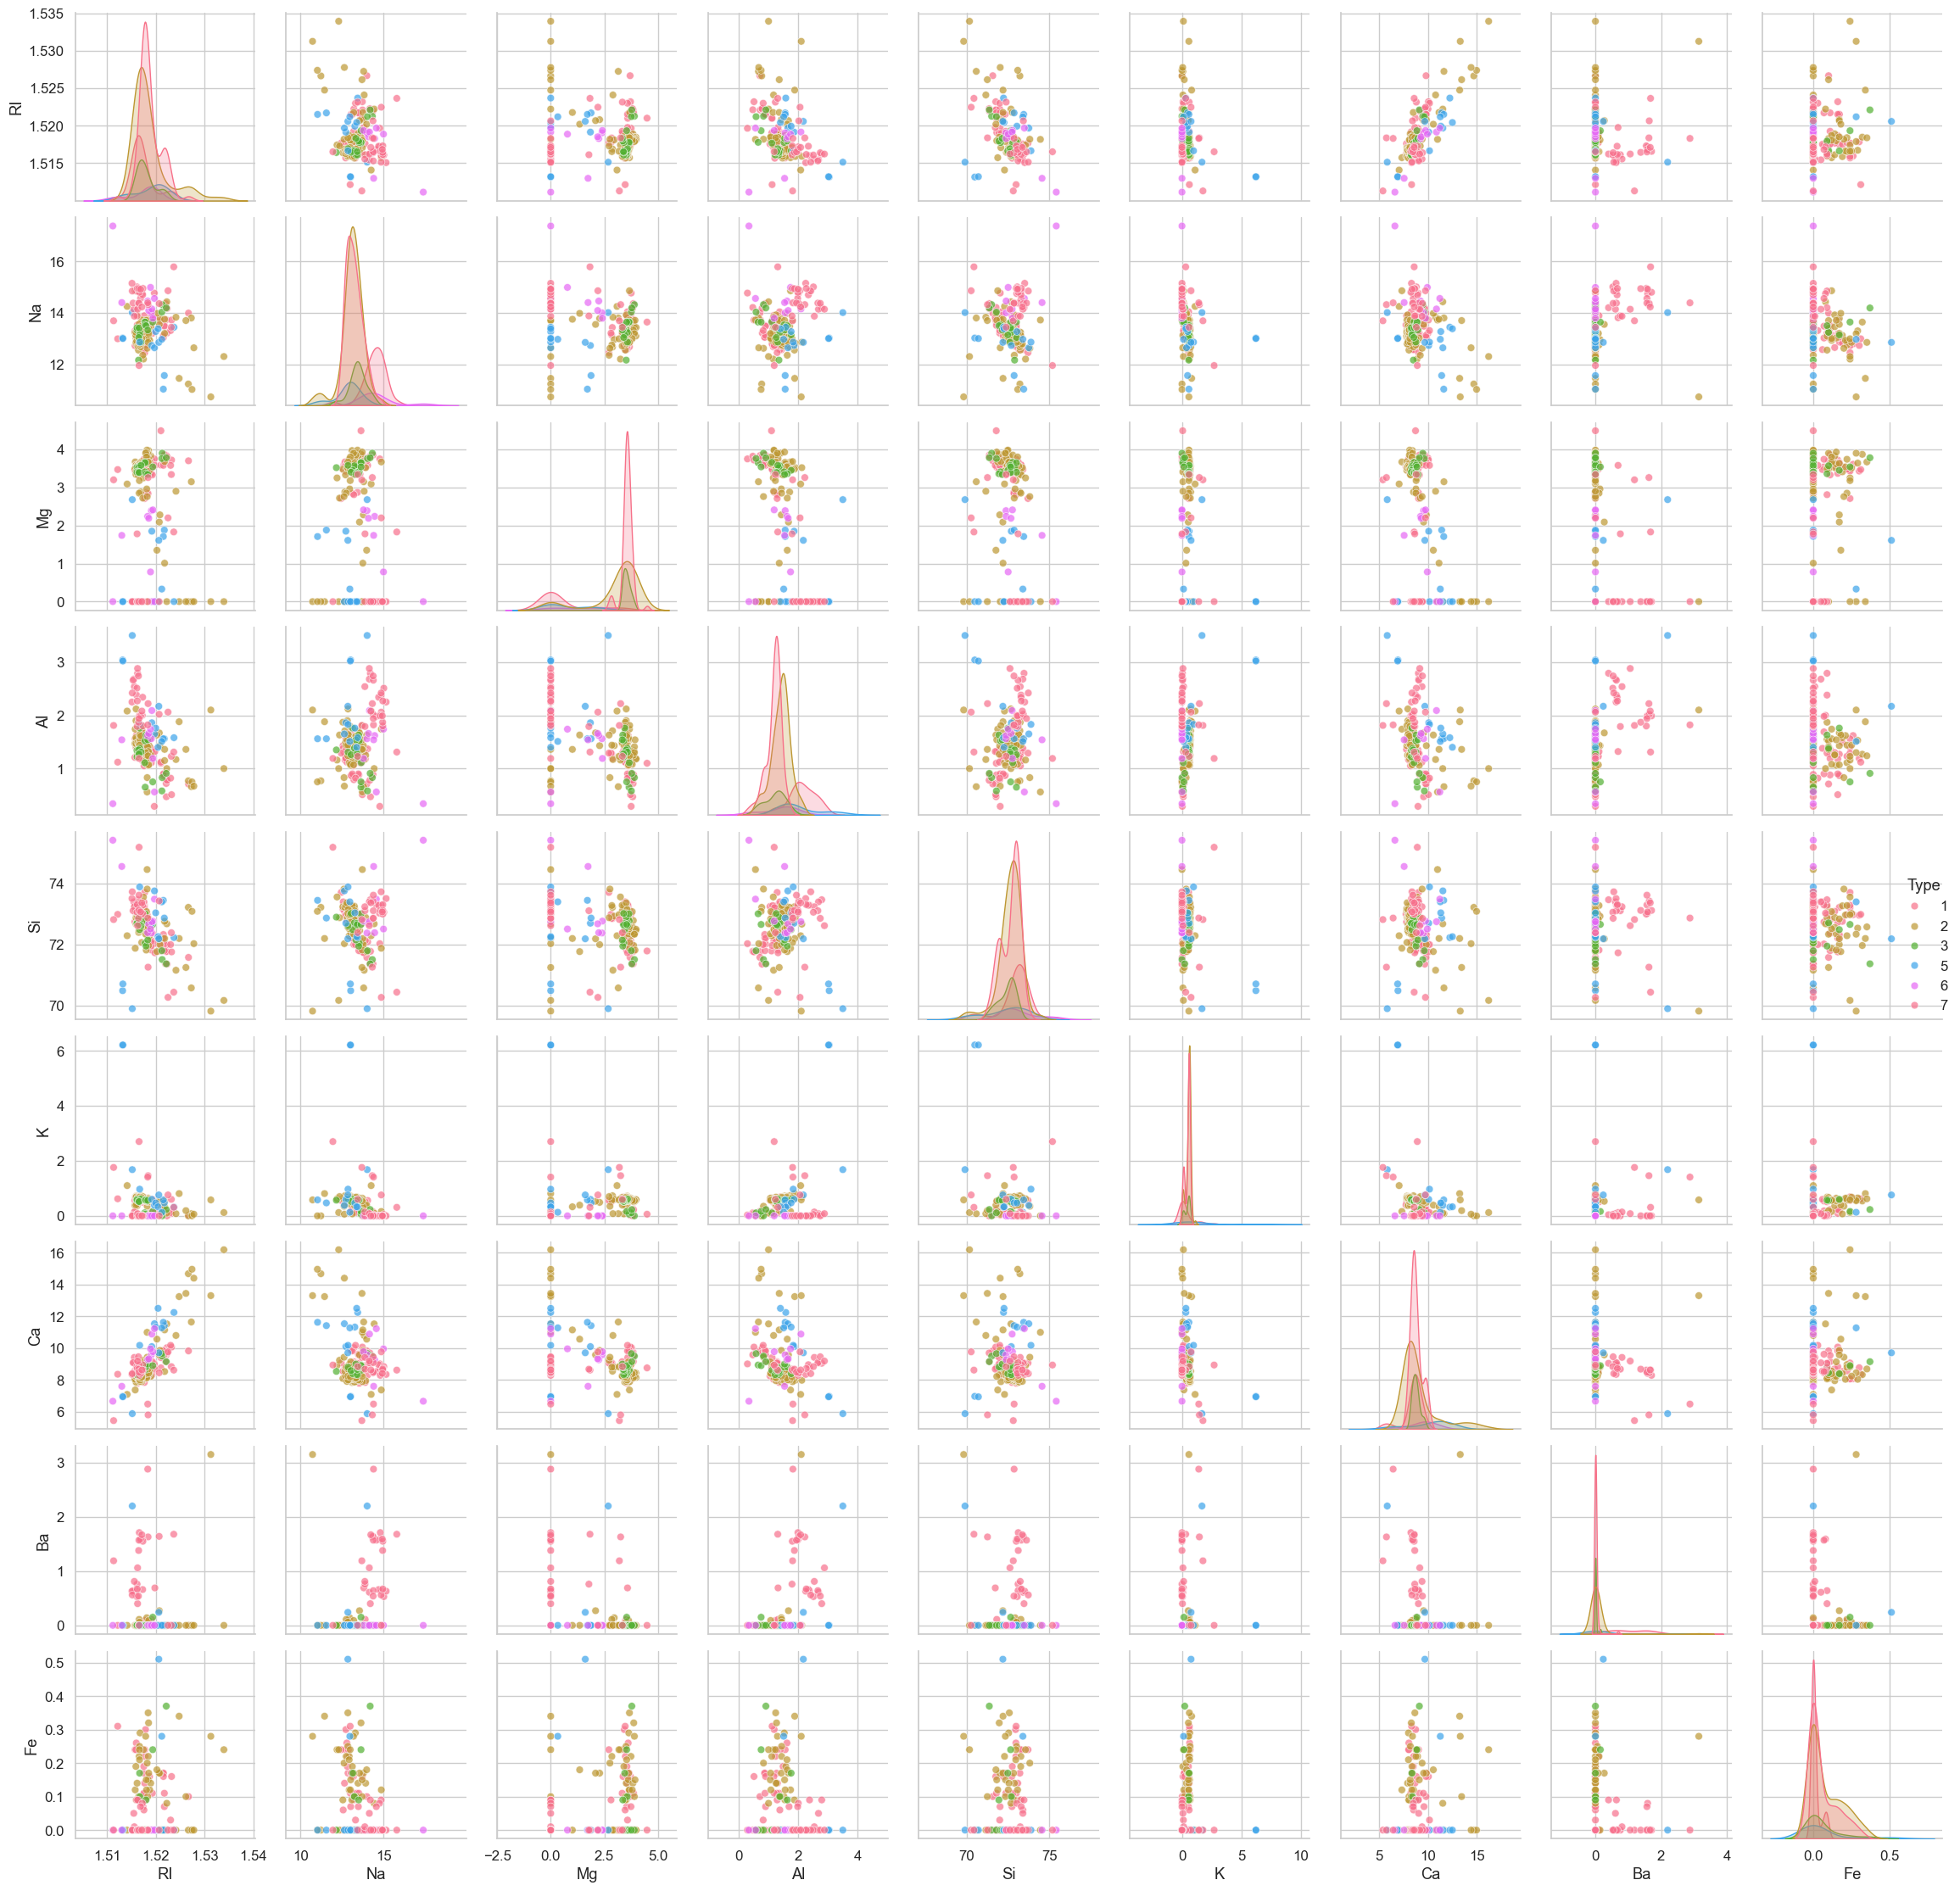

In [14]:
# ----- 3. Pairwise Feature Relationships -----
sns.pairplot(glass_df, hue='Type', diag_kind='kde',
             palette='husl', plot_kws={'alpha': 0.7, 's': 40})
plt.tight_layout()
plt.show()

### KDE Plot for feature distribution

C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1331614176.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1331614176.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1331614176.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


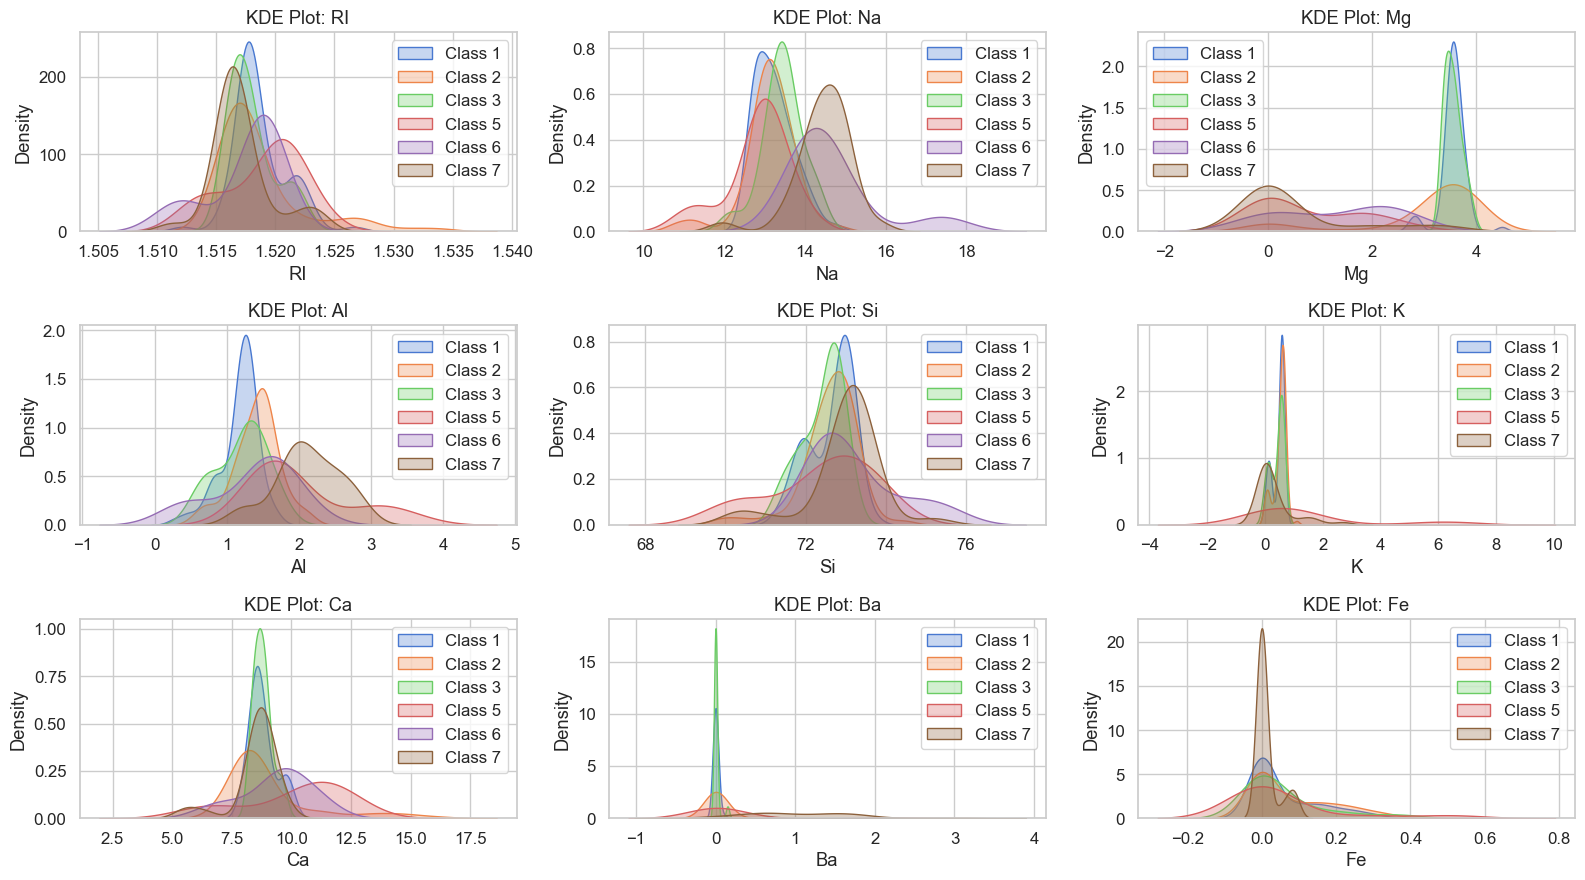

In [15]:
# ----- 4. KDE Plots for Feature Distributions (Per Class) -----
features = glass_df.drop(columns='Type').columns
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, feature in enumerate(features):
    for cls in sorted(glass_df['Type'].unique()):
        sns.kdeplot(
            data=glass_df[glass_df['Type'] == cls],
            x=feature, label=f"Class {cls}", ax=axes[idx], fill=True, alpha=0.3)
    axes[idx].set_title(f"KDE Plot: {feature}")
    axes[idx].legend()
    axes[idx].grid(True)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove empty subplots

plt.tight_layout()
plt.show()

### Boxplot for each feature

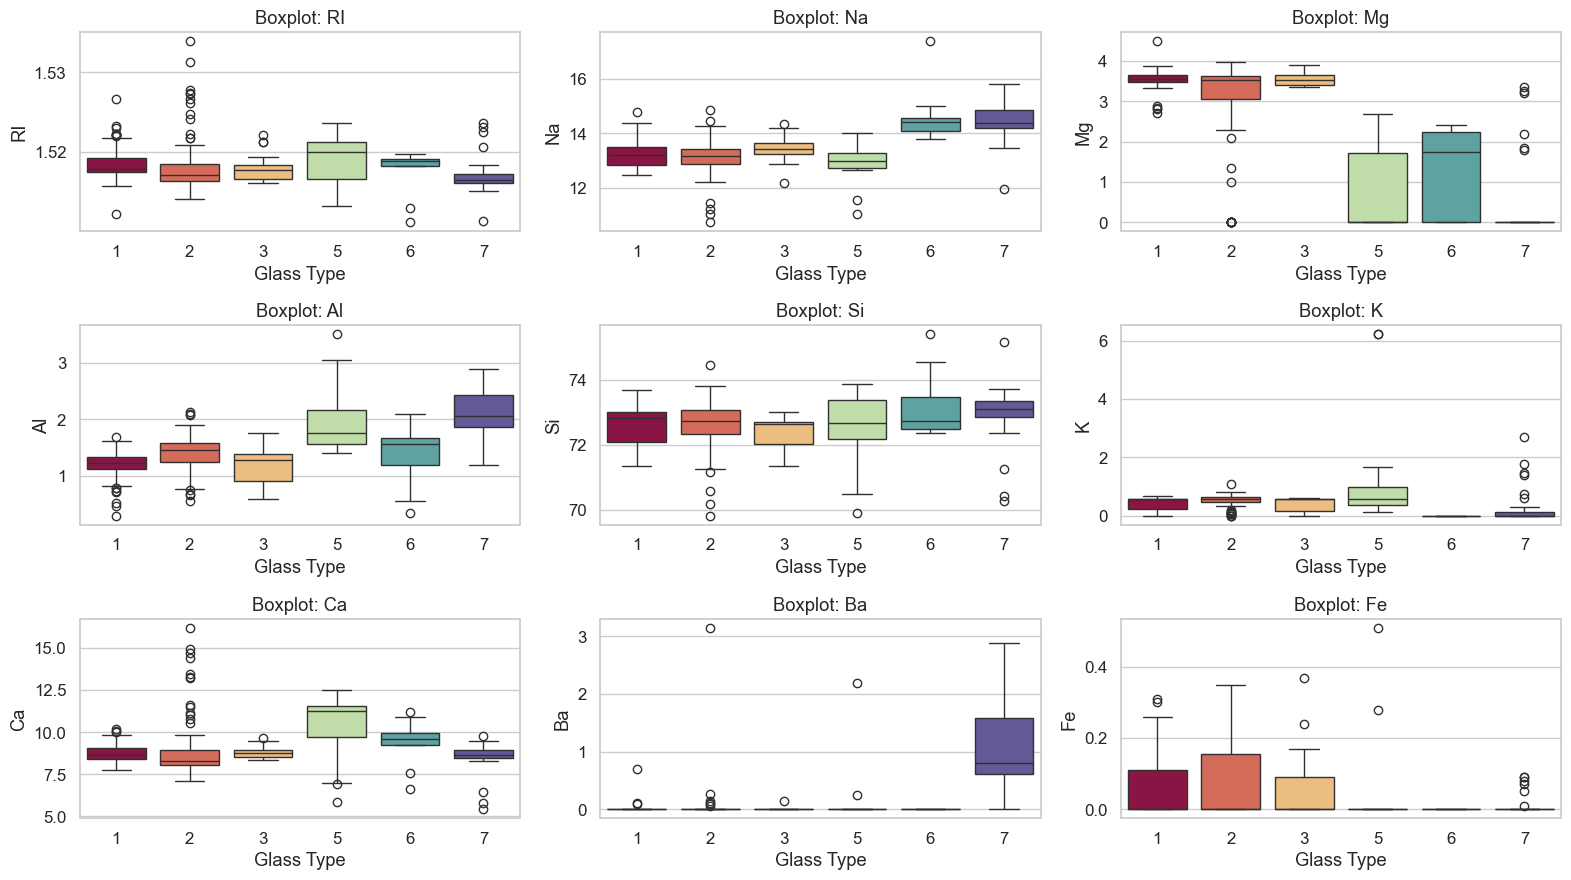

In [16]:
# ----- 5. Boxplots for Feature Distributions Across Classes -----
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.boxplot(
        data=glass_df,
        x='Type',
        y=feature,
        hue='Type',             # Assign hue explicitly
        legend=False,                # Avoid duplicate legend
        ax=axes[idx],
        palette='Spectral'
    )
    axes[idx].set_title(f"Boxplot: {feature}")
    axes[idx].set_xlabel("Glass Type")
    axes[idx].set_ylabel(feature)

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Violin plot

C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1154139992.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=glass_df, x='Type', y='RI', palette='husl')


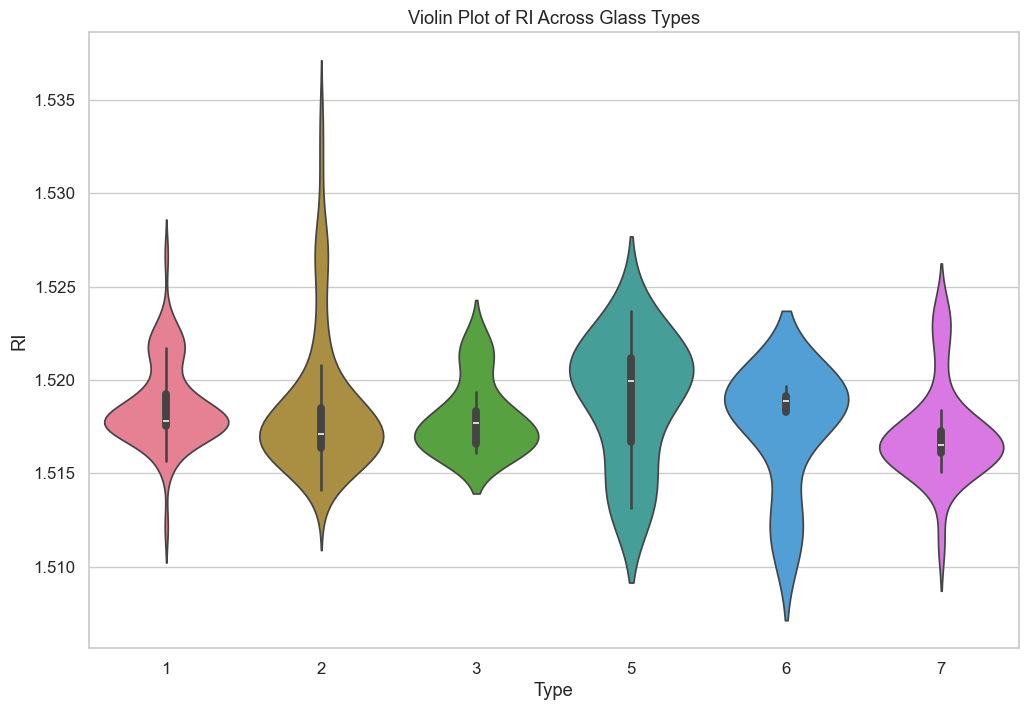

In [17]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=glass_df, x='Type', y='RI', palette='husl')
plt.title('Violin Plot of RI Across Glass Types')
plt.show()

### Class-wise Feature Mean

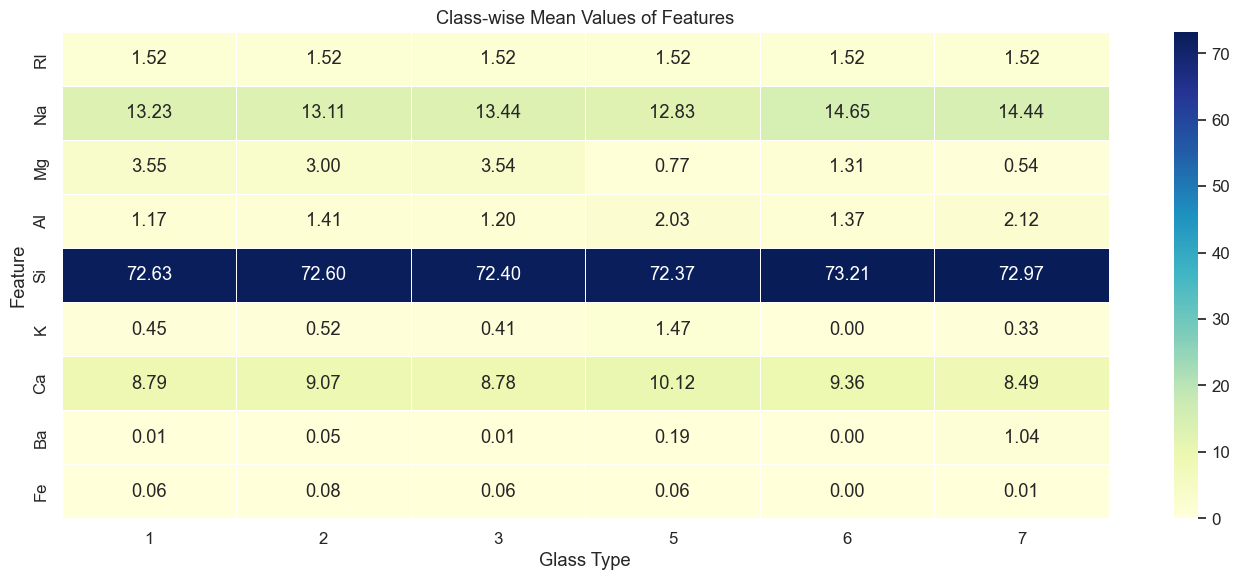

In [18]:
# ----- 6. Class-wise Feature Means -----
class_means = glass_df.groupby('Type').mean(numeric_only=True)

plt.figure(figsize=(14, 6))
sns.heatmap(class_means.T, annot=True, cmap='YlGnBu', linewidths=0.5, fmt=".2f")
plt.title("Class-wise Mean Values of Features")
plt.xlabel("Glass Type")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Comments**
- We can see that the SI (Silicon) feature has the highest mean across all classes, indicating its significance in glass composition.

## III) Logistic regression

### Data Processing

**Check skewness**

In [19]:
# ----- 2. Check Skewness for Transformation -----
numeric_cols = glass_df.drop(columns=["Type"]).columns
skew_values = glass_df[numeric_cols].apply(skew).sort_values(ascending=False)
print("\nSkewness of numeric features:\n", skew_values)


Skewness of numeric features:
 K     6.499244
Ba    3.382711
Ca    2.036282
Fe    1.734845
RI    1.636389
Al    0.931780
Na    0.462413
Si   -0.739392
Mg   -1.138009
dtype: float64


**Reduce skewness and make data smoother**

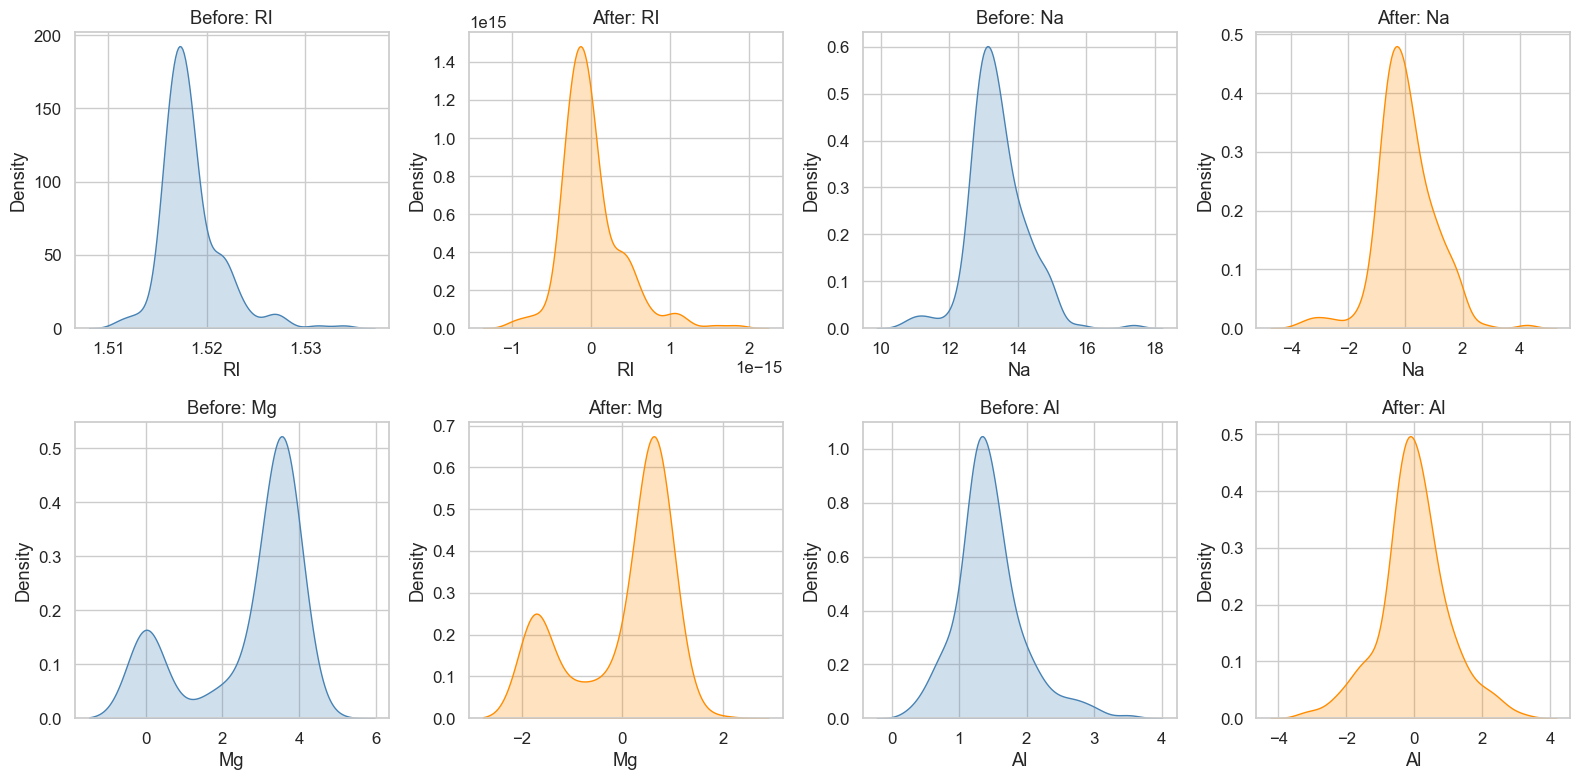

In [20]:
# ----- 3. Apply Power Transform (Box-Cox or Yeo-Johnson) -----
# PowerTransformer handles automatic skew correction (Yeo-Johnson works with zeros and negatives)
power_transformer = PowerTransformer(method='yeo-johnson')
glass_df_transformed = glass_df.copy()
glass_df_transformed[numeric_cols] = power_transformer.fit_transform(glass_df[numeric_cols])

# Select 4 features to visualize
selected_features = numeric_cols[:4]  

# 2 rows, 4 columns (before/after side by side per feature)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(selected_features):
    row = i // 2
    col_pos = (i % 2) * 2  # 0 or 2 → aligns before/after plots

    # Before transformation
    sns.kdeplot(glass_df[col], ax=axes[row, col_pos], fill=True, color='steelblue')
    axes[row, col_pos].set_title(f'Before: {col}')

    # After transformation
    sns.kdeplot(glass_df_transformed[col], ax=axes[row, col_pos + 1], fill=True, color='darkorange')
    axes[row, col_pos + 1].set_title(f'After: {col}')

plt.tight_layout()
plt.show()

### Dimension Reduction

**Apply PCA to detect outliers**

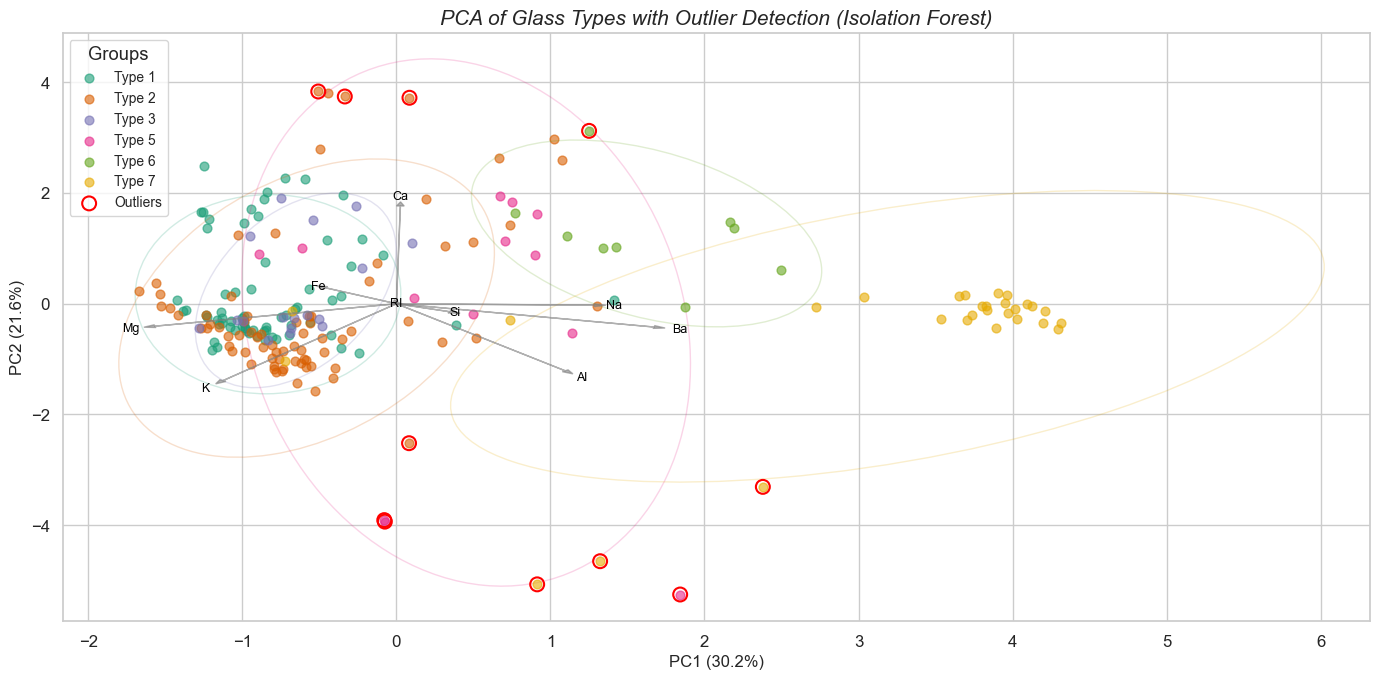

Isolation Forest detected 11 outliers out of 213 samples (5.16%).

Outlier count by Type:
Type
2    4
5    3
7    3
6    1
Name: count, dtype: int64


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# 1. Feature extraction
X = glass_df_transformed.drop(columns=["Type"]).values
y = glass_df_transformed["Type"]
feature_names = glass_df_transformed.drop(columns=["Type"]).columns

# 2. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_ * 100
components = pca.components_

# 3. Prepare PCA dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Type'] = y.values

# 4. Isolation Forest for Outlier Detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
pca_df['Outlier'] = iso_forest.fit_predict(X_pca)  # -1 = outlier, 1 = normal
outliers = np.where(pca_df['Outlier'] == -1)[0]

# 5. Plotting with Ellipses and Outliers
def confidence_ellipse(x, y, ax, n_std=1.96, facecolor='none', **kwargs):
    if x.size <= 1:
        return
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Plotting
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Plot PCA by true type with ellipses
palette = sns.color_palette("Dark2", len(pca_df['Type'].unique()))
for i, label in enumerate(pca_df['Type'].unique()):
    subset = pca_df[pca_df['Type'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], label=f'Type {label}', s=40, alpha=0.6, color=palette[i])
    confidence_ellipse(subset['PC1'], subset['PC2'], ax, edgecolor=palette[i], alpha=0.2)

# Highlight outliers
outliers = pca_df[pca_df['Outlier'] == -1]
ax.scatter(outliers['PC1'], outliers['PC2'],
           edgecolors='red', facecolors='none', s=100, linewidths=1.5, label='Outliers')

# Axis formatting
ax.set_xlabel(f"PC1 ({explained[0]:.1f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({explained[1]:.1f}%)", fontsize=12)
ax.set_title("PCA of Glass Types with Outlier Detection (Isolation Forest)", fontsize=15, fontstyle='italic')
ax.legend(title="Groups", loc='best', fontsize=10)
ax.grid(True)

# Add loading vectors
loadings = components.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(feature_names):
    ax.arrow(0, 0, loadings[i, 0]*2, loadings[i, 1]*2,
             color='gray', alpha=0.6, head_width=0.05)
    ax.text(loadings[i, 0]*2.2, loadings[i, 1]*2.2, feature,
            color='black', ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 6. Summary of outliers
num_outliers = (pca_df['Outlier'] == -1).sum()
total_samples = len(pca_df)
percent_outliers = (num_outliers / total_samples) * 100

print(f"Isolation Forest detected {num_outliers} outliers out of {total_samples} samples ({percent_outliers:.2f}%).\n")
print("Outlier count by Type:")
print(pca_df[pca_df['Outlier'] == -1]['Type'].value_counts())

In [23]:
# Step 1: Add the Outlier flag back to the original DataFrame
glass_df_with_outlier_flag = glass_df_transformed.copy()
glass_df_with_outlier_flag['Outlier'] = iso_forest.predict(X_pca)

# Step 2: Filter to keep only non-outliers (Outlier == 1)
glass_df_clean = glass_df_with_outlier_flag[glass_df_with_outlier_flag['Outlier'] == 1].drop(columns='Outlier').reset_index(drop=True)

# Step 3: Report results
print(f"Original dataset (after remove duplicates) size: {glass_df_transformed.shape[0]}")
print(f"Filtered dataset size (outliers removed): {glass_df_clean.shape[0]}")

Original dataset (after remove duplicates) size: 213
Filtered dataset size (outliers removed): 202


**LDA Projection (another approach)**

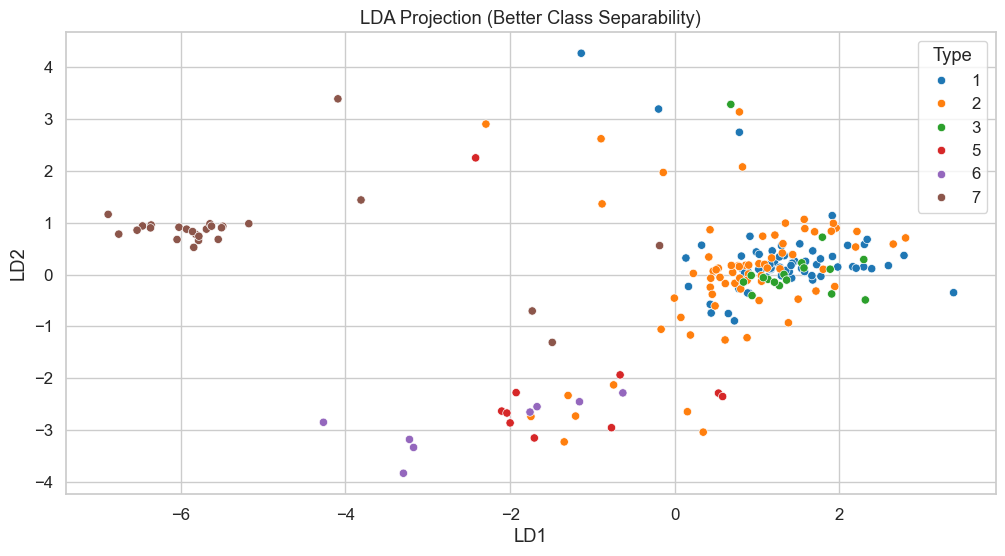

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = glass_df_clean.drop(columns=["Type"]).values
y = glass_df_clean["Type"]
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

lda_df = pd.DataFrame(X_lda, columns=["LD1", "LD2"])
lda_df["Type"] = y

sns.scatterplot(data=lda_df, x="LD1", y="LD2", hue="Type", palette="tab10")
plt.title("LDA Projection (Better Class Separability)")
plt.show()

### Build model (with lasso/ridge/elastic net)

**Data Splitting**

In [25]:
# 1. Separate features and targets
X = glass_df_clean.drop(columns=["Type"])  
y_class = glass_df_clean["Type"]           
y_reg = y_class.astype("int")                  

# 2. Train-test split for classification
X_train, X_test, y_train_cls, y_test_cls = train_test_split(
    X, y_class, stratify=y_class, random_state=42
)

# 3. Train-test split for regression (same split, but using y_reg)
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, stratify=y_class, random_state=42
)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.utils import Bunch

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  

# ----------------------
# Setup
# ----------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
os.makedirs("saved_models", exist_ok=True)

clf_models = {
    "Logistic L2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000),
    "Logistic L1": LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000),
    "ElasticNet": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=2000)
}

clf_params = {
    "Logistic L2": {
        "clf__C": np.logspace(-4, 4, 15)
    },
    "Logistic L1": {
        "clf__C": np.logspace(-4, 4, 15)
    },
    "ElasticNet": {
        "clf__C": np.logspace(-4, 4, 15),
        "clf__l1_ratio": np.linspace(0.1, 0.9, 9)
    }
}

clf_results = {}

**Training**


====== Logistic L2 (with SMOTE pipeline) ======


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best Params: {'clf__C': 13.89495494373136}
Train    - Accuracy: 0.7285, F1: 0.7692, Precision: 0.7279, Recall: 0.8618
Test     - Accuracy: 0.5882, F1: 0.6885, Precision: 0.7145, Recall: 0.7554
Test Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.59      0.67        17
           2       0.45      0.28      0.34        18
           3       0.29      1.00      0.44         4
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         2
           7       0.78      1.00      0.88         7

    accuracy                           0.59        51
   macro avg       0.71      0.76      0.69        51
weighted avg       0.64      0.59      0.59        51



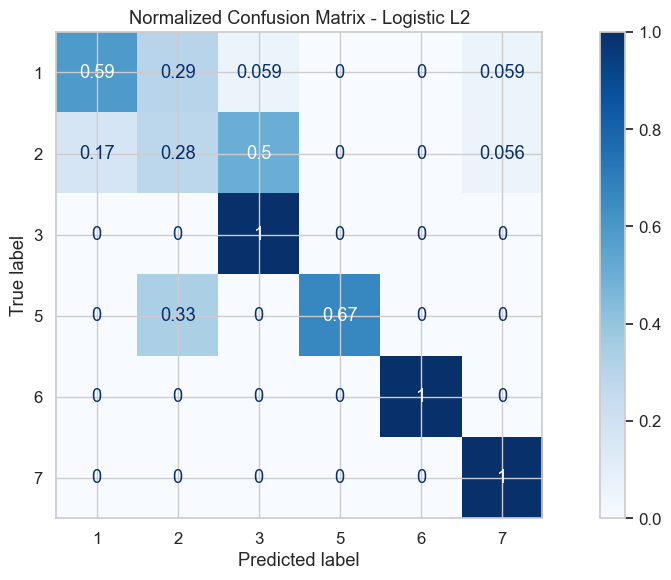

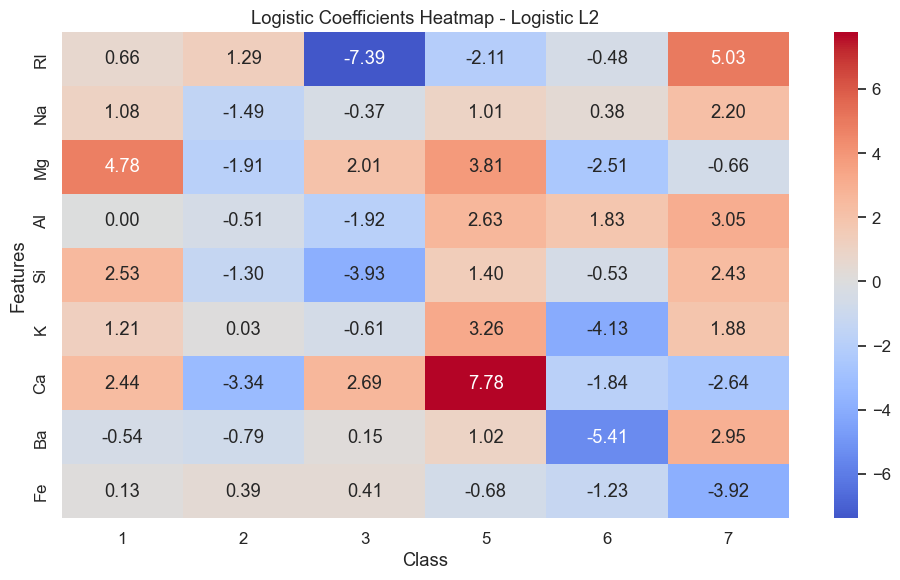

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEs

Logistic L2 CV F1 (macro): 0.6202 ± 0.0942


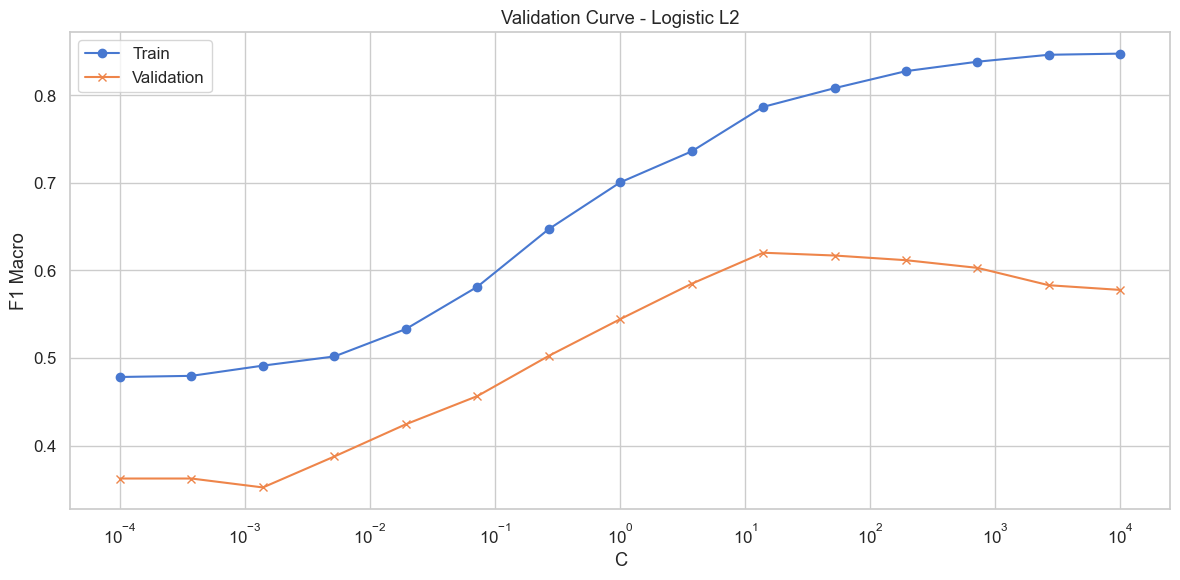


====== Logistic L1 (with SMOTE pipeline) ======
Best Params: {'clf__C': 13.89495494373136}
Train    - Accuracy: 0.7483, F1: 0.8045, Precision: 0.7754, Recall: 0.8711
Test     - Accuracy: 0.5882, F1: 0.6885, Precision: 0.7145, Recall: 0.7554
Test Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.59      0.67        17
           2       0.45      0.28      0.34        18
           3       0.29      1.00      0.44         4
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         2
           7       0.78      1.00      0.88         7

    accuracy                           0.59        51
   macro avg       0.71      0.76      0.69        51
weighted avg       0.64      0.59      0.59        51



c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


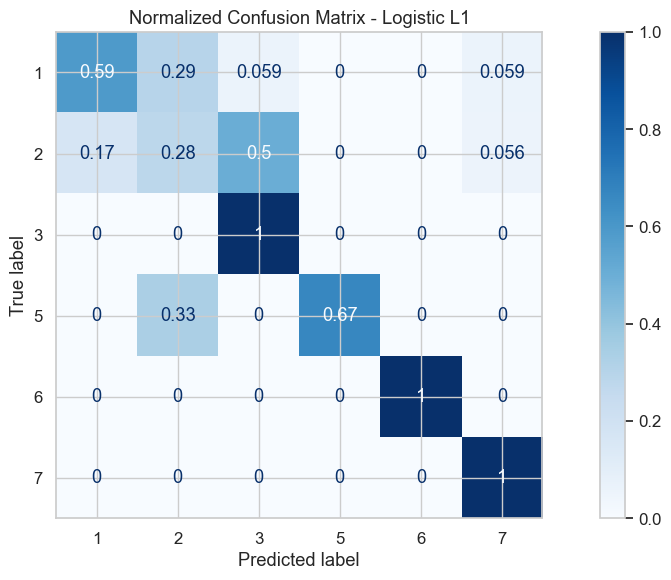

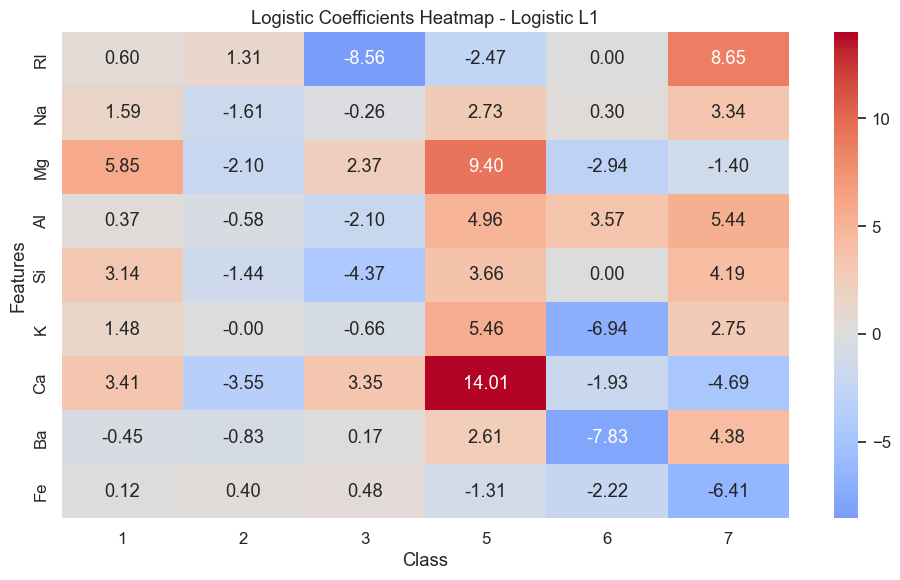

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEs

Logistic L1 CV F1 (macro): 0.6234 ± 0.0846


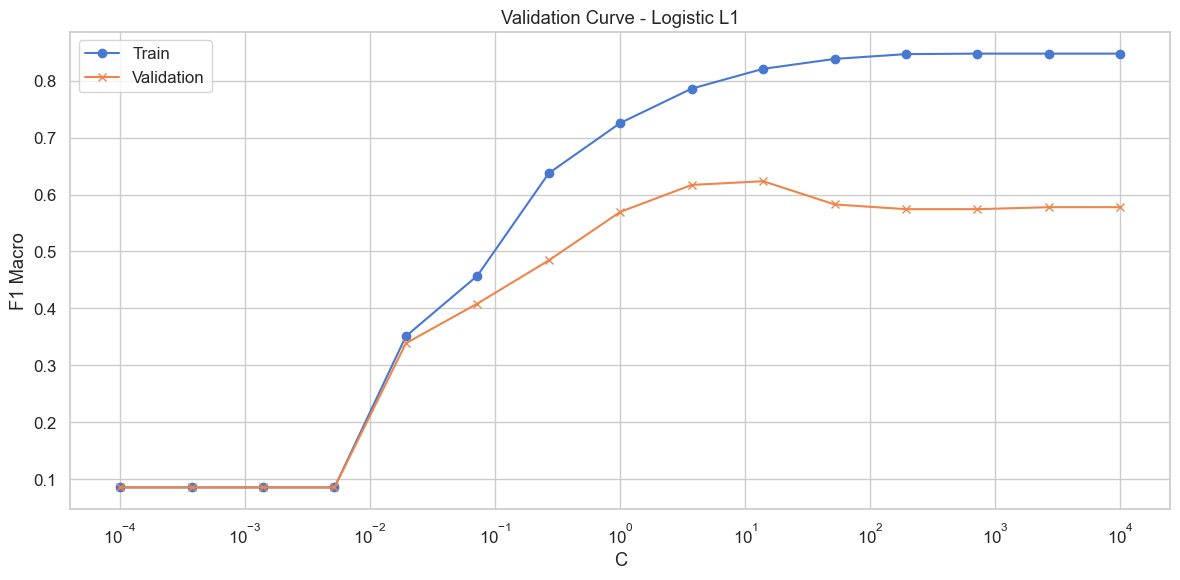


====== ElasticNet (with SMOTE pipeline) ======


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best Params: {'clf__C': 51.79474679231202, 'clf__l1_ratio': 0.8}
Train    - Accuracy: 0.7881, F1: 0.8625, Precision: 0.8501, Recall: 0.8895
Test     - Accuracy: 0.5882, F1: 0.6638, Precision: 0.6649, Recall: 0.7549
Test Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.53      0.62        17
           2       0.46      0.33      0.39        18
           3       0.33      1.00      0.50         4
           5       1.00      0.67      0.80         3
           6       0.67      1.00      0.80         2
           7       0.78      1.00      0.88         7

    accuracy                           0.59        51
   macro avg       0.66      0.75      0.66        51
weighted avg       0.63      0.59      0.58        51



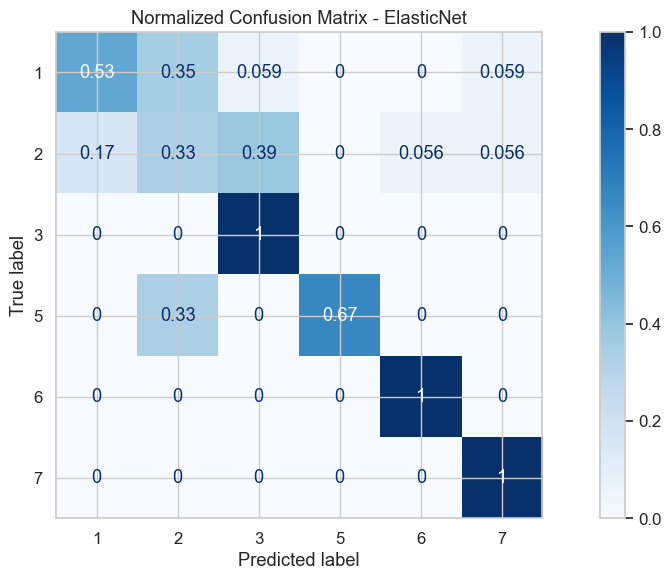

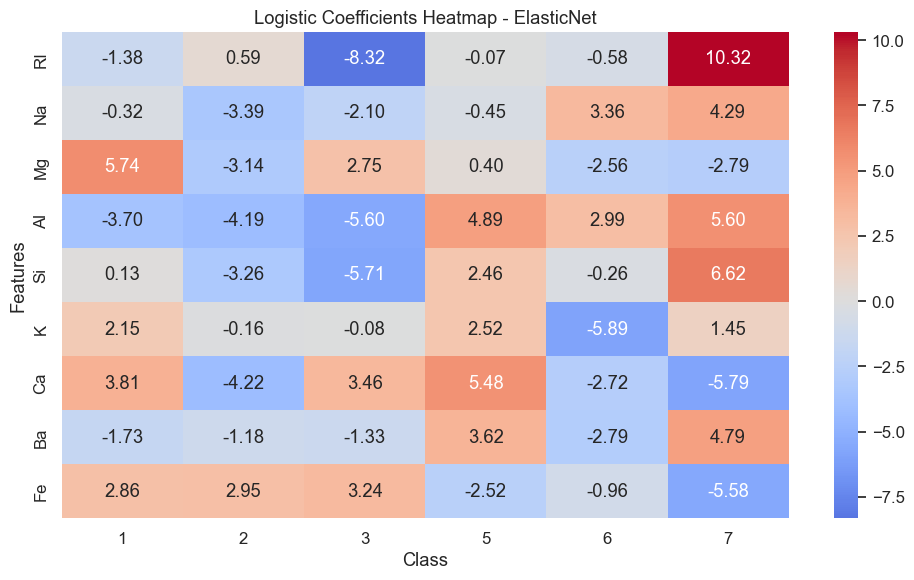

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEs

ElasticNet CV F1 (macro): 0.6745 ± 0.0686


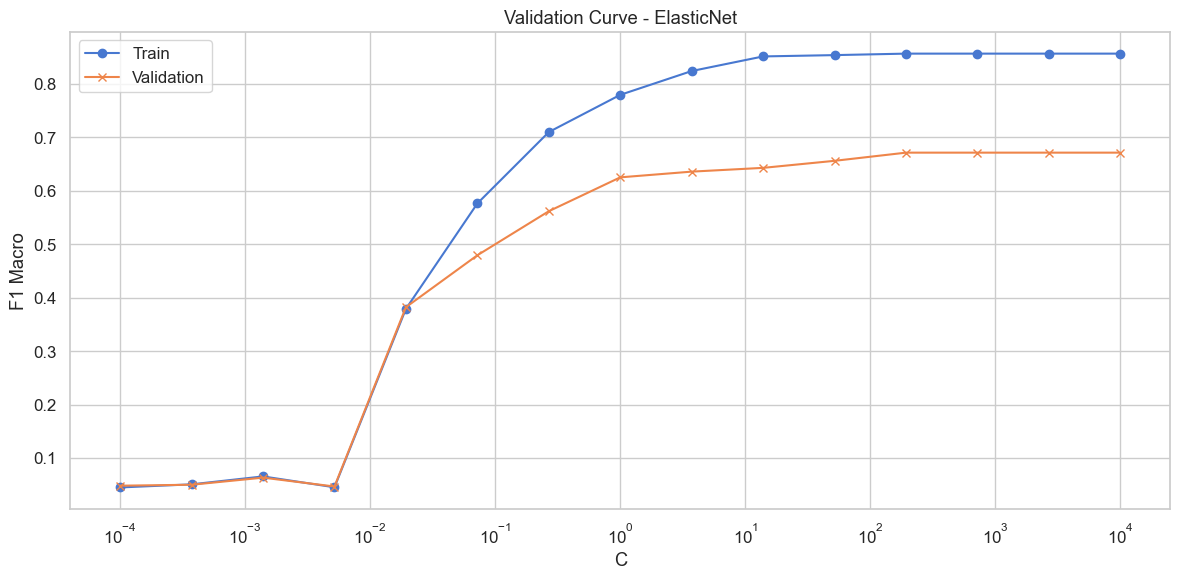

In [27]:
# ----------------------
# Training Loop
# ----------------------
for name, model in clf_models.items():
    print(f"\n====== {name} (with SMOTE pipeline) ======")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(k_neighbors=2, random_state=42)),
        ('clf', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=clf_params[name],
        cv=skf,
        scoring='f1_macro',
        n_jobs=-1
    )

    grid.fit(X_train, y_train_cls)

    # Save model
    joblib.dump(grid.best_estimator_, f"saved_models/{name.replace(' ', '_')}_best.pkl")

    # ----------------------
    # Training Performance
    # ----------------------
    y_train_pred = grid.predict(X_train)
    acc_train = accuracy_score(y_train_cls, y_train_pred)
    f1_train = f1_score(y_train_cls, y_train_pred, average='macro')
    prec_train = precision_score(y_train_cls, y_train_pred, average='macro')
    rec_train = recall_score(y_train_cls, y_train_pred, average='macro')

    # ----------------------
    # Test Performance
    # ----------------------
    y_test_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)

    acc_test = accuracy_score(y_test_cls, y_test_pred)
    f1_test = f1_score(y_test_cls, y_test_pred, average='macro')
    prec_test = precision_score(y_test_cls, y_test_pred, average='macro')
    rec_test = recall_score(y_test_cls, y_test_pred, average='macro')

    clf_results[name] = Bunch(
        BestParams=grid.best_params_,
        Accuracy_Train=acc_train,
        F1_Train=f1_train,
        Precision_Train=prec_train,
        Recall_Train=rec_train,
        Accuracy_Test=acc_test,
        F1_Test=f1_test,
        Precision_Test=prec_test,
        Recall_Test=rec_test
    )

    # Save reults
    model_results[name] = {
        'accuracy': acc_test,
        'f1_macro': f1_test,
        'precision': prec_test,
        'recall': rec_test
    }

    # ----------------------
    # Print Metrics
    # ----------------------
    print(f"Best Params: {grid.best_params_}")
    print(f"Train    - Accuracy: {acc_train:.4f}, F1: {f1_train:.4f}, Precision: {prec_train:.4f}, Recall: {rec_train:.4f}")
    print(f"Test     - Accuracy: {acc_test:.4f}, F1: {f1_test:.4f}, Precision: {prec_test:.4f}, Recall: {rec_test:.4f}")
    print("Test Classification Report:\n", classification_report(y_test_cls, y_test_pred))

    # ----------------------
    # Confusion Matrix
    # ----------------------
    ConfusionMatrixDisplay.from_predictions(
        y_test_cls, y_test_pred, cmap='Blues', normalize='true'
    )
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Coefficients Heatmap
    # ----------------------
    feature_names = X.columns.tolist()
    best_model = grid.best_estimator_.named_steps['clf']
    coef_df = pd.DataFrame(best_model.coef_, columns=feature_names)
    coef_df["Class"] = best_model.classes_

    plt.figure(figsize=(10, 6))
    sns.heatmap(coef_df.set_index("Class").T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f'Logistic Coefficients Heatmap - {name}')
    plt.ylabel("Features")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Cross-validation Score
    # ----------------------
    cv_f1 = cross_val_score(grid.best_estimator_, X_train, y_train_cls, cv=skf, scoring='f1_macro')
    print(f"{name} CV F1 (macro): {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

    # ----------------------
    # Validation Curve
    # ----------------------
    param_range = np.logspace(-4, 4, 15)
    train_scores, val_scores = validation_curve(
        pipe, X_train, y_train_cls,
        param_name="clf__C", param_range=param_range,
        cv=skf, scoring="f1_macro", n_jobs=-1
    )

    plt.figure()
    plt.semilogx(param_range, np.mean(train_scores, axis=1), label="Train", marker='o')
    plt.semilogx(param_range, np.mean(val_scores, axis=1), label="Validation", marker='x')
    plt.xlabel("C")
    plt.ylabel("F1 Macro")
    plt.title(f"Validation Curve - {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

**L1 and L2 Comparisons**

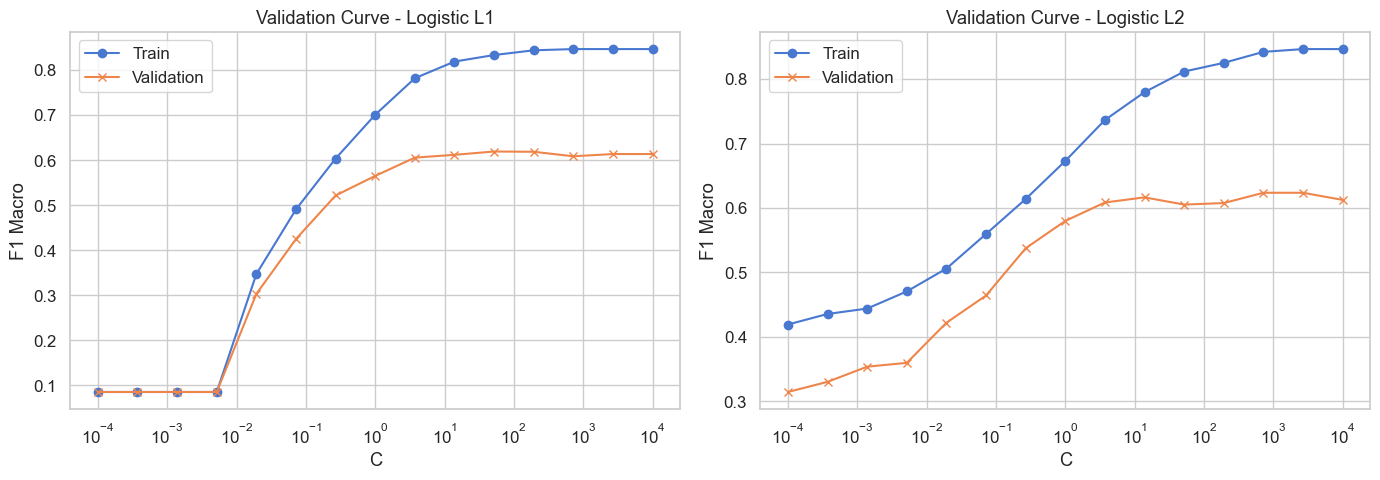

In [28]:
# -------------------------------
# Prepare parameter range
# -------------------------------
param_range = np.logspace(-4, 4, 15)

# -------------------------------
# Rebuild pipeline for L1 and L2
# -------------------------------
pipe_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=2, random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear'))
])

pipe_l2 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=2, random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, penalty='l2', solver='liblinear'))
])

# -------------------------------
# Validation curves
# -------------------------------
train_scores_l1, val_scores_l1 = validation_curve(
    pipe_l1, X_train, y_train_cls,
    param_name="clf__C", param_range=param_range,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_scores_l2, val_scores_l2 = validation_curve(
    pipe_l2, X_train, y_train_cls,
    param_name="clf__C", param_range=param_range,
    cv=5, scoring="f1_macro", n_jobs=-1
)

# -------------------------------
# Plot
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic L1
axes[0].semilogx(param_range, np.mean(train_scores_l1, axis=1), label="Train", marker='o')
axes[0].semilogx(param_range, np.mean(val_scores_l1, axis=1), label="Validation", marker='x')
axes[0].set_title("Validation Curve - Logistic L1")
axes[0].set_xlabel("C")
axes[0].set_ylabel("F1 Macro")
axes[0].legend()

# Logistic L2
axes[1].semilogx(param_range, np.mean(train_scores_l2, axis=1), label="Train", marker='o')
axes[1].semilogx(param_range, np.mean(val_scores_l2, axis=1), label="Validation", marker='x')
axes[1].set_title("Validation Curve - Logistic L2")
axes[1].set_xlabel("C")
axes[1].set_ylabel("F1 Macro")
axes[1].legend()

plt.tight_layout()
plt.show()

**ROC Curve**

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


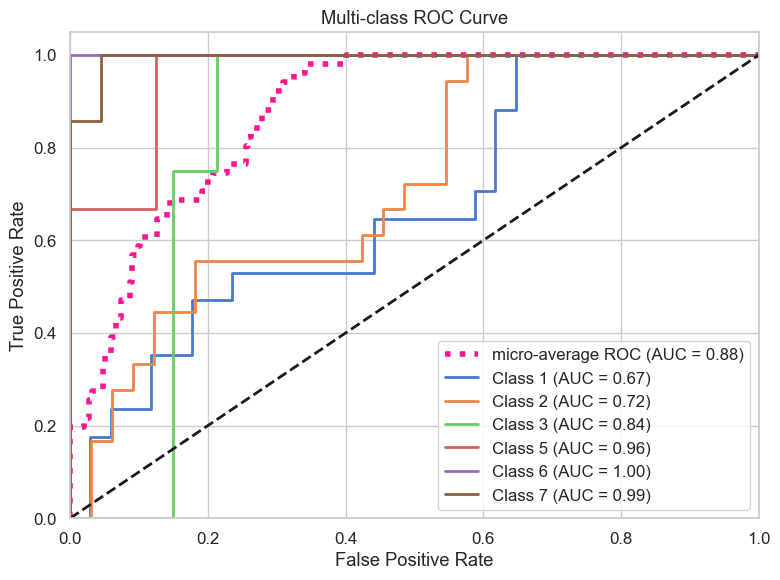

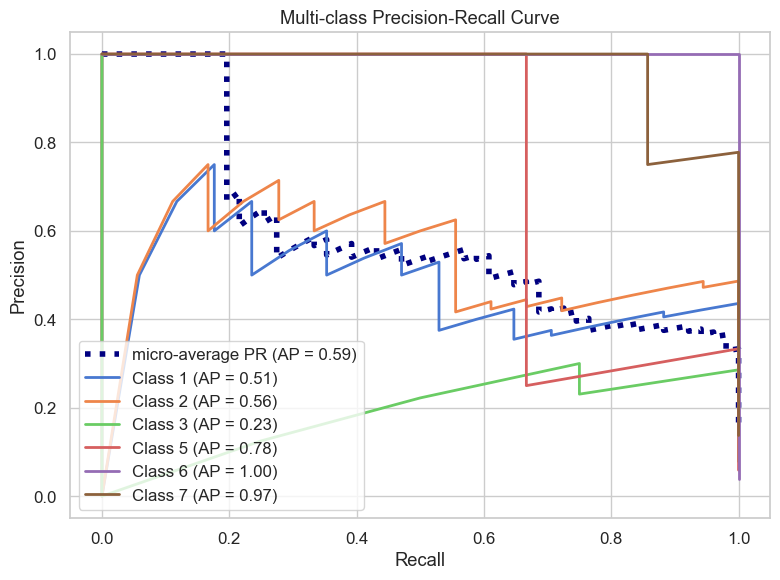

In [29]:

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Binarize the output for multi-class ROC/PR computation
y_test_bin = label_binarize(y_test_cls, classes=np.unique(y_test_cls))
n_classes = y_test_bin.shape[1]
class_names = ["1", "2", "3", "5", "6", "7"]

# Predict probabilities
y_score = best_model.predict_proba(X_test)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Micro-average PR
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot PR
plt.figure(figsize=(8, 6))
plt.plot(recall["micro"], precision["micro"],
         label=f'micro-average PR (AP = {average_precision["micro"]:.2f})', color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'Class {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

**All results**

In [30]:
for name, result in model_results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}, F1 Macro = {result['f1_macro']:.4f}, "
          f"Precision = {result['precision']:.4f}, Recall = {result['recall']:.4f}")

Logistic L2: Accuracy = 0.5882, F1 Macro = 0.6885, Precision = 0.7145, Recall = 0.7554
Logistic L1: Accuracy = 0.5882, F1 Macro = 0.6885, Precision = 0.7145, Recall = 0.7554
ElasticNet: Accuracy = 0.5882, F1 Macro = 0.6638, Precision = 0.6649, Recall = 0.7549


## IV) Other models

### 1) Random Forest

In [31]:
RF_glass_df = glass_df.copy()
print(RF_glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[213 rows x 10 columns]


In [32]:
RF_glass_df['Type'].value_counts()

Type
2    76
1    69
7    29
3    17
5    13
6     9
Name: count, dtype: int64

In [33]:
RF_glass_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 26.4 KB


**X and Y split**

In [34]:
X = RF_glass_df.drop(['Type'], axis = 1)
y = RF_glass_df['Type']

**Train, test**

In [35]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [36]:
X_train.shape, X_test.shape

((170, 9), (43, 9))

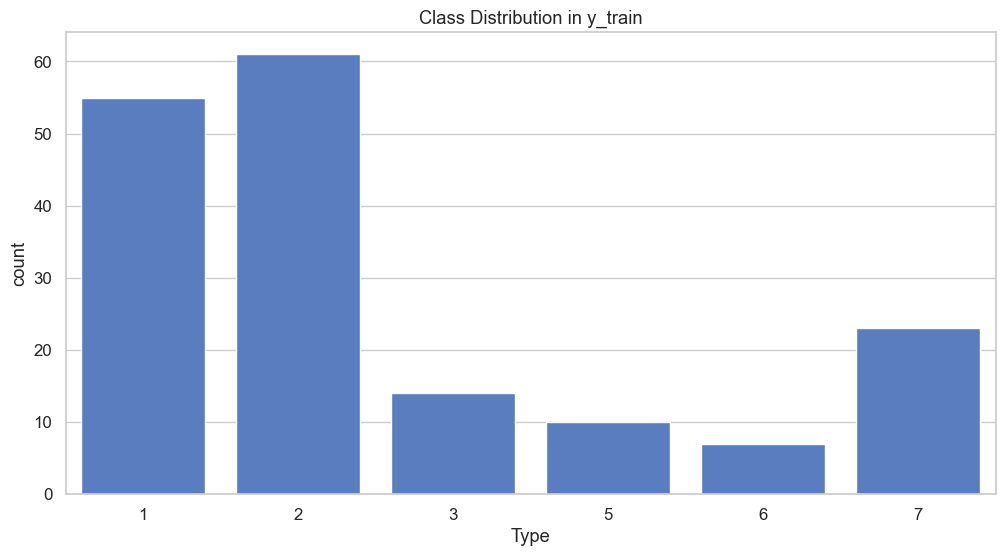

In [37]:
sns.countplot(x=y_train)
plt.title('Class Distribution in y_train')
plt.show()

**With 10 decision-trees**

In [39]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier

rf = RandomForestClassifier(n_estimators=10, random_state=42)


# fit the model

rf.fit(X_train, y_train)


# Predict the Test set results

y_pred = rf.predict(X_test)


# Check accuracy score

from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.8140


**With 50 decision-trees**

In [40]:
# instantiate the classifier with n_estimators = 50

rfc_50 = RandomForestClassifier(n_estimators=50, random_state=42)



# fit the model to the training set

rfc_50.fit(X_train, y_train)



# Predict on the test set results

y_pred_50 = rfc_50.predict(X_test)



# Check accuracy score

print('Model accuracy score with 50 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_50)))

Model accuracy score with 50 decision-trees : 0.8605


**Save results**

In [41]:
rf_accuracy = accuracy_score(y_test, y_pred_50)
rf_f1 = f1_score(y_test, y_pred_50, average='macro')
rf_precision = precision_score(y_test, y_pred_50, average='macro')
rf_recall = recall_score(y_test, y_pred_50, average='macro')

model_results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'f1_macro': rf_f1,
    'precision': rf_precision,
    'recall': rf_recall
}

**With 100 decision-trees**

In [42]:
# instantiate the classifier with n_estimators = 100

rfc_100 = RandomForestClassifier(n_estimators=100, random_state=42)



# fit the model to the training set

rfc_100.fit(X_train, y_train)



# Predict on the test set results

y_pred_100 = rfc_100.predict(X_test)



# Check accuracy score

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.8605


**Find the best number of trees**

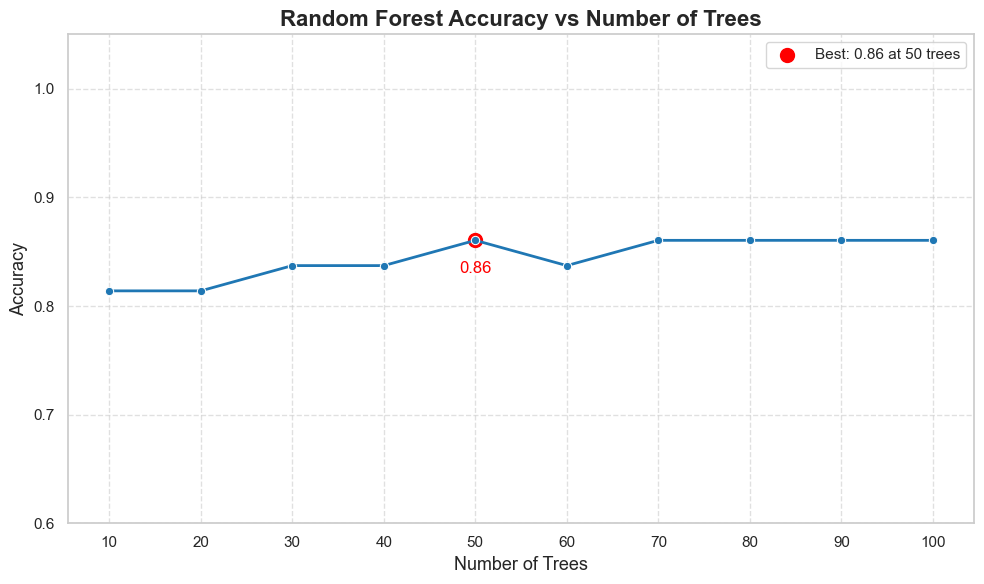

In [43]:
tree_counts = list(range(10, 101, 10))
accuracies = []

for n in tree_counts:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Style đẹp của seaborn
sns.set(style="whitegrid")

# Tìm giá trị tốt nhất
best_acc = max(accuracies)
best_n = tree_counts[accuracies.index(best_acc)]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=tree_counts, y=accuracies, marker='o', linewidth=2, color='tab:blue')
plt.scatter([best_n], [best_acc], color='red', s=100, label=f'Best: {best_acc:.2f} at {best_n} trees')

# Thêm chú thích
plt.text(best_n, best_acc - 0.03, f'{best_acc:.2f}', color='red', ha='center', fontsize=12)

# Trang trí thêm
plt.title("Random Forest Accuracy vs Number of Trees", fontsize=16, fontweight='bold')
plt.xlabel("Number of Trees", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.ylim(0.6, 1.05)
plt.xticks(tree_counts)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Feature Scores**

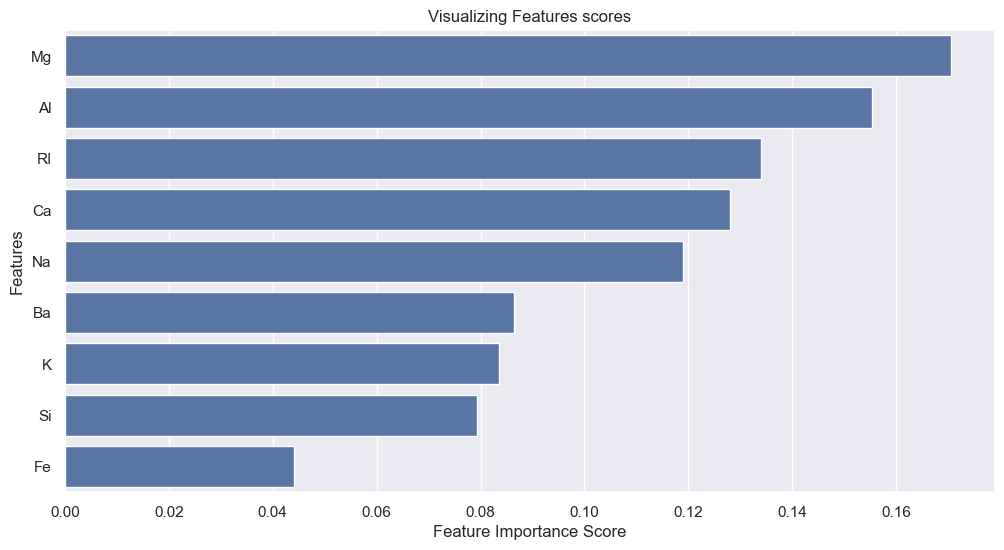

In [45]:
# view the feature scores

feature_scores = pd.Series(rfc_50.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
# Set the style
sns.set(style="darkgrid")
plt.xlabel('Feature Importance Score')

plt.ylabel('Features')

plt.title("Visualizing Features scores")

plt.show()

**Confusion Matrix**

In [46]:
# Classification Report
print(classification_report(y_test, y_pred_50))

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        14
           2       0.81      0.87      0.84        15
           3       1.00      0.67      0.80         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         6

    accuracy                           0.86        43
   macro avg       0.84      0.84      0.83        43
weighted avg       0.87      0.86      0.86        43



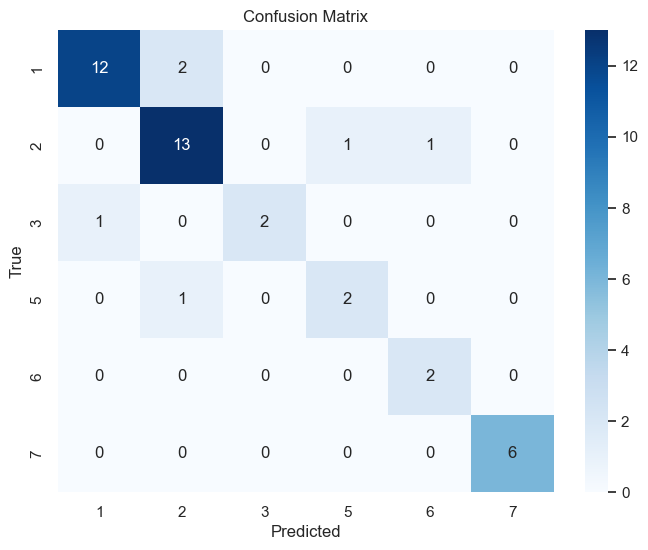

In [47]:
# Print the Confusion Matrix and slice it into four categories

from sklearn.metrics import confusion_matrix

cm_1 = confusion_matrix(y_test, y_pred_50)

plt.figure(figsize=(8, 6))
sns.heatmap( cm_1, annot=True, fmt="d", cmap="Blues", xticklabels= RF_glass_df['Type'].unique(), yticklabels=RF_glass_df['Type'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Analysis**
- Class 1: 12 out of 14 correctly predicted; slight confusion with class 2.
- Class 2: Very accurate (13/15); only 2 misclassifications (1 to class 3, 1 to class 5).
- Class 3: 2/3 correctly predicted; 1 confused with class 1.
- Class 5: 2/3 correct; 1 misclassified as class 2.
- Class 6 & 7: Both perfectly classified (100% accuracy).

**Comments**:
- The model consistently achieves strong accuracy between 0.82 and 0.86, peaking at 50 trees. Beyond this point, performance gains are negligible, indicating that a moderately sized forest is sufficient.
- Accuracy stabilizes after 50 trees, suggesting that adding more trees does not improve generalization and only increases computational cost.
- The confusion matrix shows excellent classification with minimal misclassifications. The model achieves perfect predictions for classes 6 and 7, highlighting its strong performance on certain categories.
- Random Forest is well-suited for small, multi-class datasets. It is naturally resistant to overfitting, does not require feature scaling, and provides feature importance scores for interpretability and feature selection.

### 2) SVM


**Comments**
- Note that SVM is highly sensitive to the scale of the data, so feature scaling is necessary — using StandardScaler.

**X and Y split**

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svm_glass_df = glass_df.copy()

X = svm_glass_df.drop("Type", axis=1)
y = svm_glass_df["Type"]

**Train and test**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42,
)

**Model**

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


svm_kernel_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])


param_grid = {
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__C': [1, 10, 100, 1000, 10000],
    'model__gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'model__degree': [1, 2, 3]
}


grid_search = GridSearchCV(svm_kernel_pipe, param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'model__C': 10, 'model__degree': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


**Confusion Matrix**

Training Accuracy: 0.8365
Test Accuracy: 0.7407


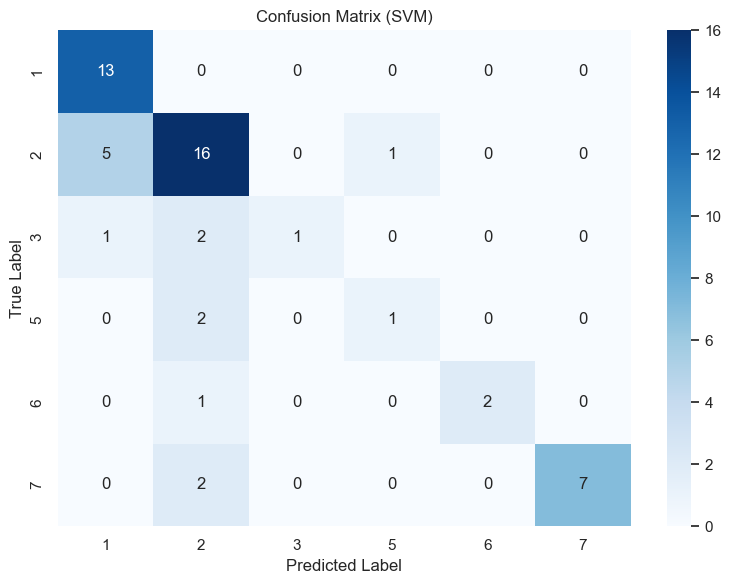

In [53]:
y_pred_train = grid_search.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_acc:.4f}")

y_pred_test = grid_search.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_test, y_pred_test)
labels = sorted(set(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

**Classification Report**

In [54]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.68      1.00      0.81        13
           2       0.70      0.73      0.71        22
           3       1.00      0.25      0.40         4
           5       0.50      0.33      0.40         3
           6       1.00      0.67      0.80         3
           7       1.00      0.78      0.88         9

    accuracy                           0.74        54
   macro avg       0.81      0.63      0.67        54
weighted avg       0.77      0.74      0.73        54



**Save results**

In [55]:
svm_accuracy = accuracy_score(y_test, y_pred_test)
svm_f1 = f1_score(y_test, y_pred_test, average='macro')
svm_precision = precision_score(y_test, y_pred_test, average='macro')
svm_recall = recall_score(y_test, y_pred_test, average='macro')

model_results['SVM'] = {
    'accuracy': svm_accuracy,
    'f1_macro': svm_f1,
    'precision': svm_precision,
    'recall': svm_recall
}

**Comments**:
- SVM shows low accuracy due to severe class imbalance, which significantly impacts model performance.
- Some classes (e.g., class 3, 5, and 6) have very few samples, making it difficult for SVM to learn them effectively.
- Features overlap across classes, leading to unclear decision boundaries — for instance, classes 1 and 2 are quite similar.
- SVM parameters may not be optimized; a large C value could be causing slight overfitting.

### 3) KNN

**Split X, Y**

In [56]:
knn_glass_df = glass_df.copy()

X = knn_glass_df.drop("Type", axis=1)
y = knn_glass_df["Type"]

**Train and Test**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify = y,
)

**Model**

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])


parameters = {
    'model__algorithm': ['brute'],
    'model__leaf_size': [30, 50, 70, 90, 110],
    'model__metric': ['minkowski'],
    'model__p': [1, 2], #euclid and m
    'model__n_neighbors': [3, 5, 11, 19],
    'model__weights': ['uniform', 'distance'],
    'model__n_jobs': [-1]
}

classifier_knn = GridSearchCV(knn_pipe, parameters, cv=3)
classifier_knn = classifier_knn.fit(X_train, y_train)

print("Best KNN parameters:", classifier_knn.best_params_)

Best KNN parameters: {'model__algorithm': 'brute', 'model__leaf_size': 30, 'model__metric': 'minkowski', 'model__n_jobs': -1, 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}


**Confusion Matrix**

Training set:  1.0
Test set:  0.8518518518518519


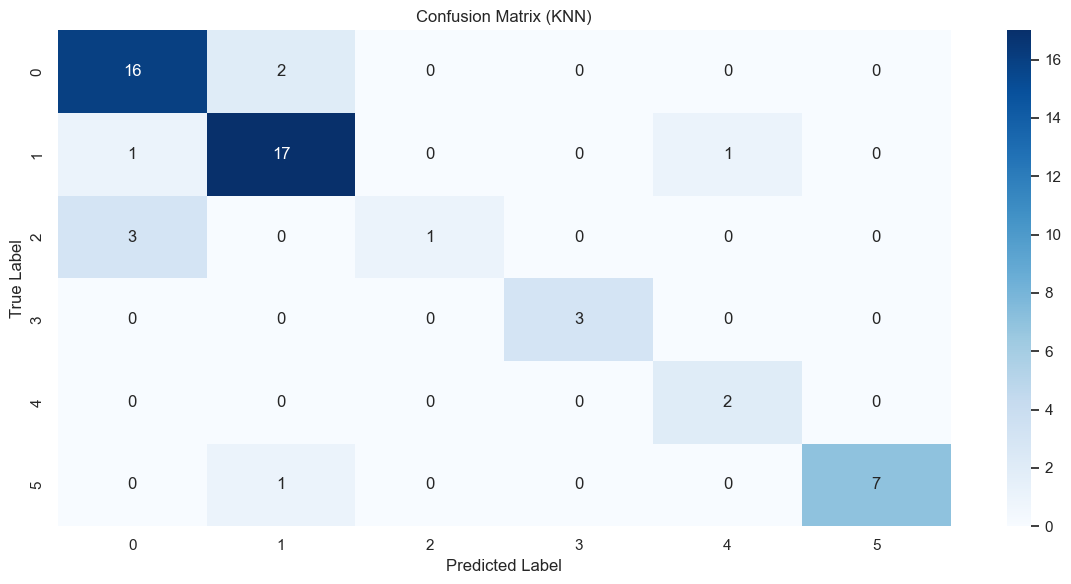

In [59]:

y_pred_knn_train = classifier_knn.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set: ", accuracy_knn_test)

cm = confusion_matrix(y_test, y_pred_knn_test)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.title("Confusion Matrix (KNN)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

**Classification Report**

In [60]:
print(classification_report(y_test, y_pred_knn_test))

              precision    recall  f1-score   support

           1       0.80      0.89      0.84        18
           2       0.85      0.89      0.87        19
           3       1.00      0.25      0.40         4
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.88      0.93         8

    accuracy                           0.85        54
   macro avg       0.89      0.82      0.81        54
weighted avg       0.87      0.85      0.84        54



**Save results**

In [61]:
knn_accuracy = accuracy_score(y_test, y_pred_knn_test)
knn_f1 = f1_score(y_test, y_pred_knn_test, average='macro')
knn_precision = precision_score(y_test, y_pred_knn_test, average='macro')
knn_recall = recall_score(y_test, y_pred_knn_test, average='macro')

model_results['KNN'] = {
    'accuracy': knn_accuracy,
    'f1_macro': knn_f1,
    'precision': knn_precision,
    'recall': knn_recall
}

**Comments**:
- Train accuracy = 1.0 → the model memorizes the training data, indicating signs of overfitting.
- Test accuracy = 85% → quite good, and higher than the previous SVM result (74%).
- Class 1 and 5 are predicted very well with minimal errors.
- Classes 2, 3, and 4 are often misclassified as class 0 or 1, likely due to limited samples and poorly separated features.
- A small k (k = 3) makes the model sensitive to noise and outliers. However, due to the small dataset size, it still performs reasonably well.
- KNN works well overall but suffers from overfitting — increasing k could help reduce overfitting, or consider alternative algorithms for better stability on imbalanced data.

### 4) XGBoost

In [62]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

**Scale features**

In [63]:
glass_df_boost = glass_df.copy()
# Features and target
X = glass_df.drop("Type", axis=1)
y = glass_df["Type"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Split X, Y**

In [64]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
# Apply SMOTE - help balance the dataset
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


**Encode target labels**

In [65]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split using encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

**Data Balancing**

In [66]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1224083209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y_train), ax=ax[0], palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_10896\1224083209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y_train_sm), ax=ax[1], palette='Set1')


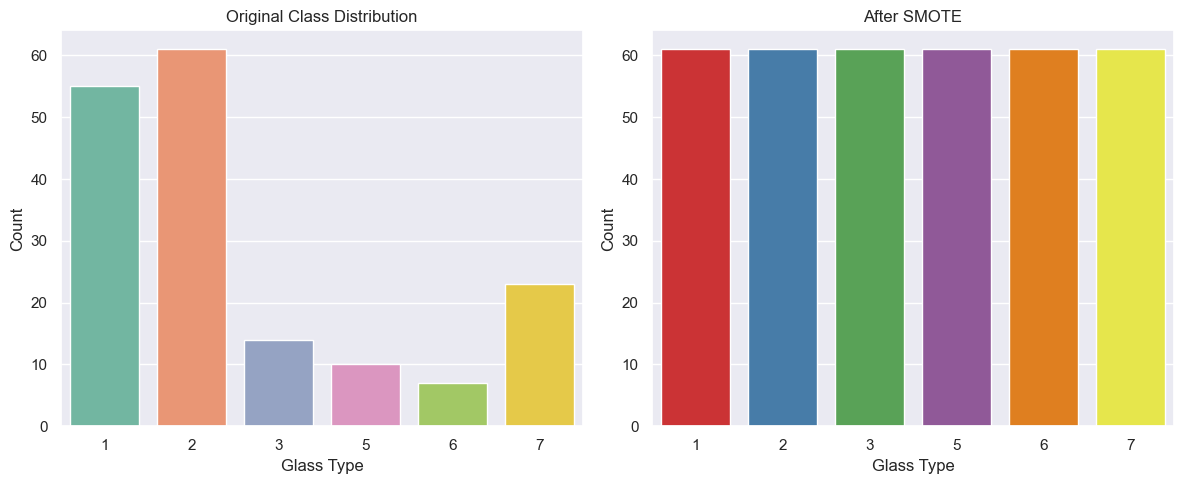

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=le.inverse_transform(y_train), ax=ax[0], palette='Set2')
ax[0].set_title("Original Class Distribution")
ax[0].set_xlabel("Glass Type")
ax[0].set_ylabel("Count")

sns.countplot(x=le.inverse_transform(y_train_sm), ax=ax[1], palette='Set1')
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Glass Type")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

**Train model**

In [68]:
xgb_model = XGBClassifier(
    objective='multi:softmax',  # For classification
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_sm, y_train_sm)

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:12:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6, ...)

**Results**

In [69]:
# Predict and decode to original labels
y_pred = xgb_model.predict(X_test)
y_pred_original = le.inverse_transform(y_pred)
y_test_original = le.inverse_transform(y_test)

**Classification Report**

In [70]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.85      0.73      0.79        15
           2       0.60      1.00      0.75         3
           3       0.75      1.00      0.86         3
           4       0.67      1.00      0.80         2
           5       0.83      0.83      0.83         6

    accuracy                           0.84        43
   macro avg       0.78      0.90      0.82        43
weighted avg       0.86      0.84      0.84        43



**Confusion Matrix**

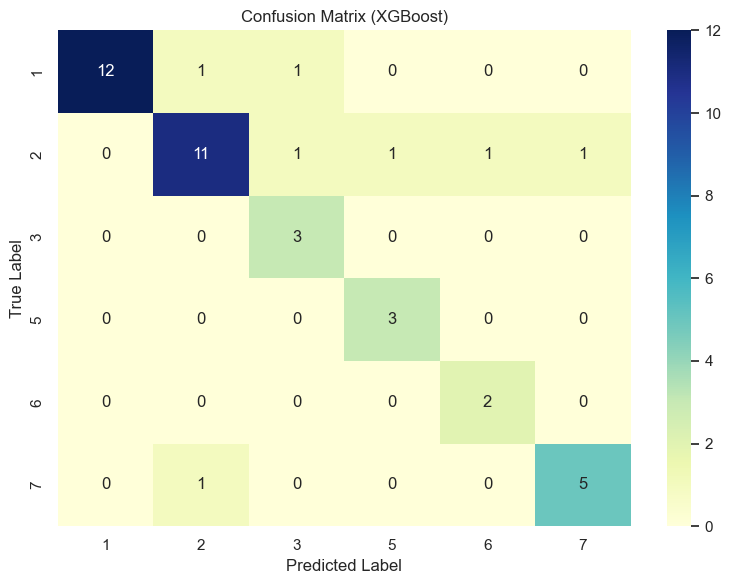

In [71]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_original)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.show()

**Feature Importance**

C:\Users\USER\AppData\Local\Temp\ipykernel_10896\3336530007.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


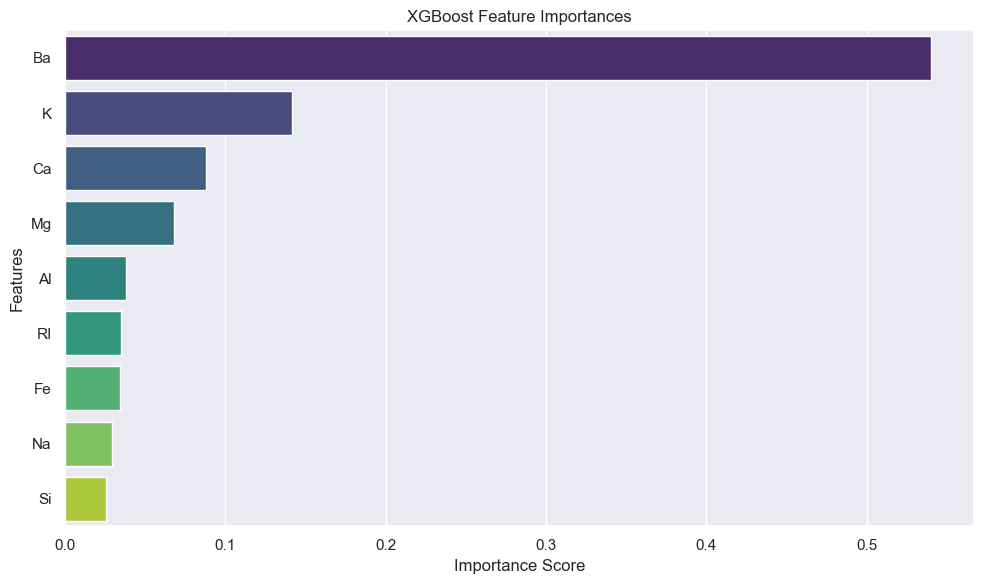

In [72]:
importances = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

**Save results**

In [73]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_precision = precision_score(y_test, y_pred, average='macro')
xgb_recall = recall_score(y_test, y_pred, average='macro')

model_results['XGBoost'] = {
    'accuracy': xgb_accuracy,
    'f1_macro': xgb_f1,
    'precision': xgb_precision,
    'recall': xgb_recall
}

### 5) Neural Network

**X and Y split**

In [155]:
X = glass_df.drop(columns=['Type'])
y = glass_df['Type']

**Train, validation, test**

In [156]:
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

**Normalize data**

In [157]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_val_scaled = scaler.transform(X_val_orig)
X_test_scaled = scaler.transform(X_test_orig)

**Data balancing**

In [159]:
ros = RandomOverSampler(random_state=42)
X_train, y_train_raw = ros.fit_resample(X_train_scaled, y_train_orig)

y_train = to_categorical(y_train_raw - 1)
y_val = to_categorical(y_val_orig - 1)
y_test = to_categorical(y_test_orig - 1)

X_val = X_val_scaled
X_test = X_test_scaled

print('X_train :', X_train.shape)
print('y_train :', y_train.shape)
print('X_val   :', X_val.shape)
print('y_val   :', y_val.shape)
print('X_test  :', X_test.shape)
print('y_test  :', y_test.shape)

X_train : (228, 9)
y_train : (228, 7)
X_val   : (53, 9)
y_val   : (53, 7)
X_test  : (54, 9)
y_test  : (54, 7)


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [160]:
# Check leakage data
def hash_sample(x):
    return hashlib.md5(np.array(x).tobytes()).hexdigest()

train_hashes = set(map(hash_sample, X_train))
val_hashes = set(map(hash_sample, X_val))
test_hashes = set(map(hash_sample, X_test))
leaked1 = train_hashes.intersection(val_hashes)
leaked2 = train_hashes.intersection(test_hashes)

print(f"Number of leaked validation samples: {len(leaked1)}")
print(f"Number of leaded test samples: {len(leaked2)}")

Number of leaked validation samples: 0
Number of leaded test samples: 0


**Model Architecture**

In [161]:
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(9,),
                kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu',
                kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),

    # Output layer
    layers.Dense(7, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'f1_score'])

model.summary()

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,743 (49.78 KB)

 Trainable params: 12,295 (48.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [162]:
# Add early stop to stop when there is no significant improvement
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=100, restore_best_weights=True)

**Training**

In [163]:
class PrintEveryN(Callback):
    def __init__(self, N):
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            train_loss = logs.get('loss', 0.0)
            train_acc = logs.get('accuracy', 0.0)
            val_loss = logs.get('val_loss', 0.0)
            val_acc = logs.get('val_accuracy', 0.0)

            print(f"Epoch {epoch+1}: "
                  f"train_loss = {train_loss:.4f}, train_accuracy = {train_acc:.4f} | "
                  f"val_loss = {val_loss:.4f}, val_accuracy = {val_acc:.4f}")

In [164]:
num_epochs = 300

history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, PrintEveryN(10)],
                    verbose=0,
                   )

Epoch 10: train_loss = 2.4266, train_accuracy = 0.5482 | val_loss = 2.7878, val_accuracy = 0.3585
Epoch 20: train_loss = 2.1118, train_accuracy = 0.6667 | val_loss = 2.4403, val_accuracy = 0.3962
Epoch 30: train_loss = 1.8184, train_accuracy = 0.7149 | val_loss = 2.2169, val_accuracy = 0.4340
Epoch 40: train_loss = 1.6038, train_accuracy = 0.7675 | val_loss = 2.0872, val_accuracy = 0.4906
Epoch 50: train_loss = 1.6287, train_accuracy = 0.7588 | val_loss = 1.9297, val_accuracy = 0.5849
Epoch 60: train_loss = 1.4716, train_accuracy = 0.7982 | val_loss = 1.8687, val_accuracy = 0.5849
Epoch 70: train_loss = 1.4168, train_accuracy = 0.7763 | val_loss = 1.8260, val_accuracy = 0.5660
Epoch 80: train_loss = 1.3569, train_accuracy = 0.7895 | val_loss = 1.7615, val_accuracy = 0.5660
Epoch 90: train_loss = 1.2613, train_accuracy = 0.8070 | val_loss = 1.7558, val_accuracy = 0.5660
Epoch 100: train_loss = 1.2063, train_accuracy = 0.8246 | val_loss = 1.6481, val_accuracy = 0.6226
Epoch 110: train_lo

**Evaluation and Visualization**

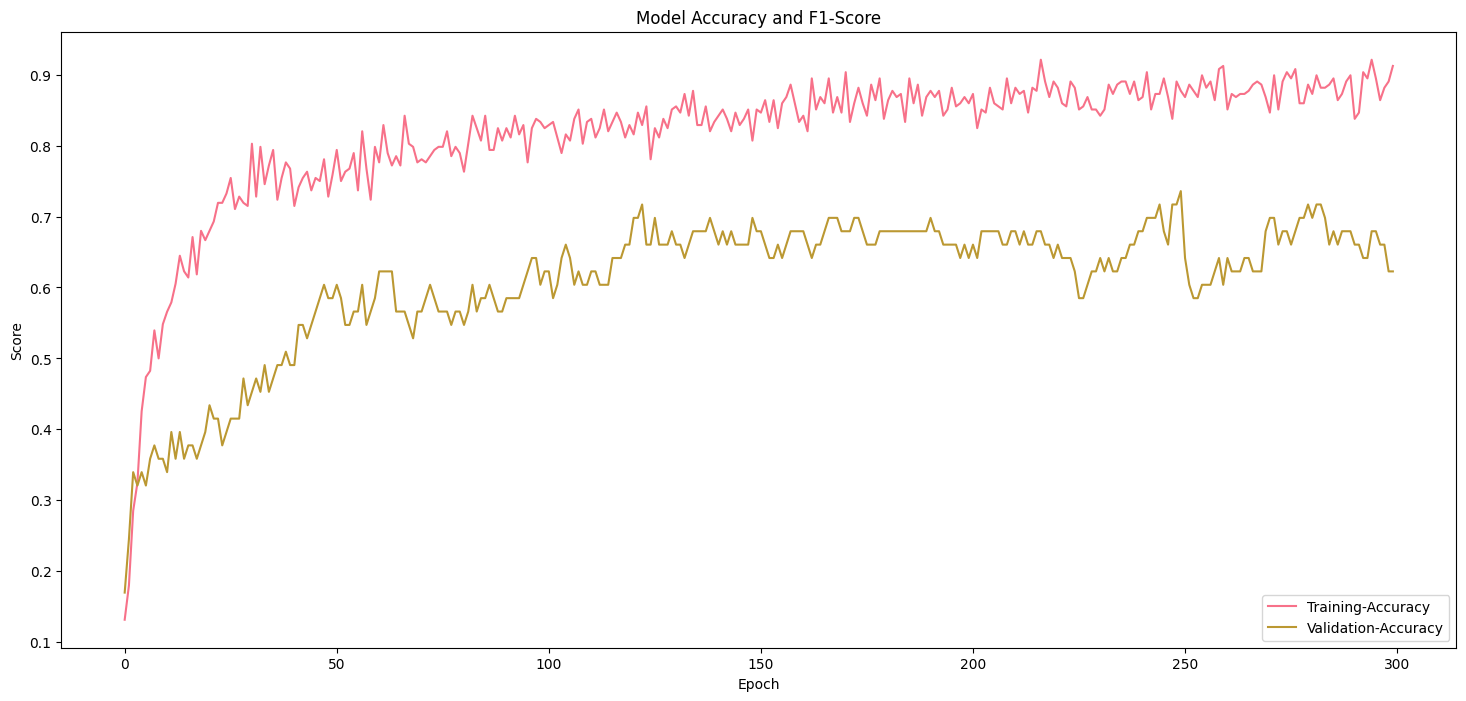

In [165]:
plt.figure(figsize=(18,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy and F1-Score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Training-Accuracy', 'Validation-Accuracy'], loc='lower right')
plt.show()

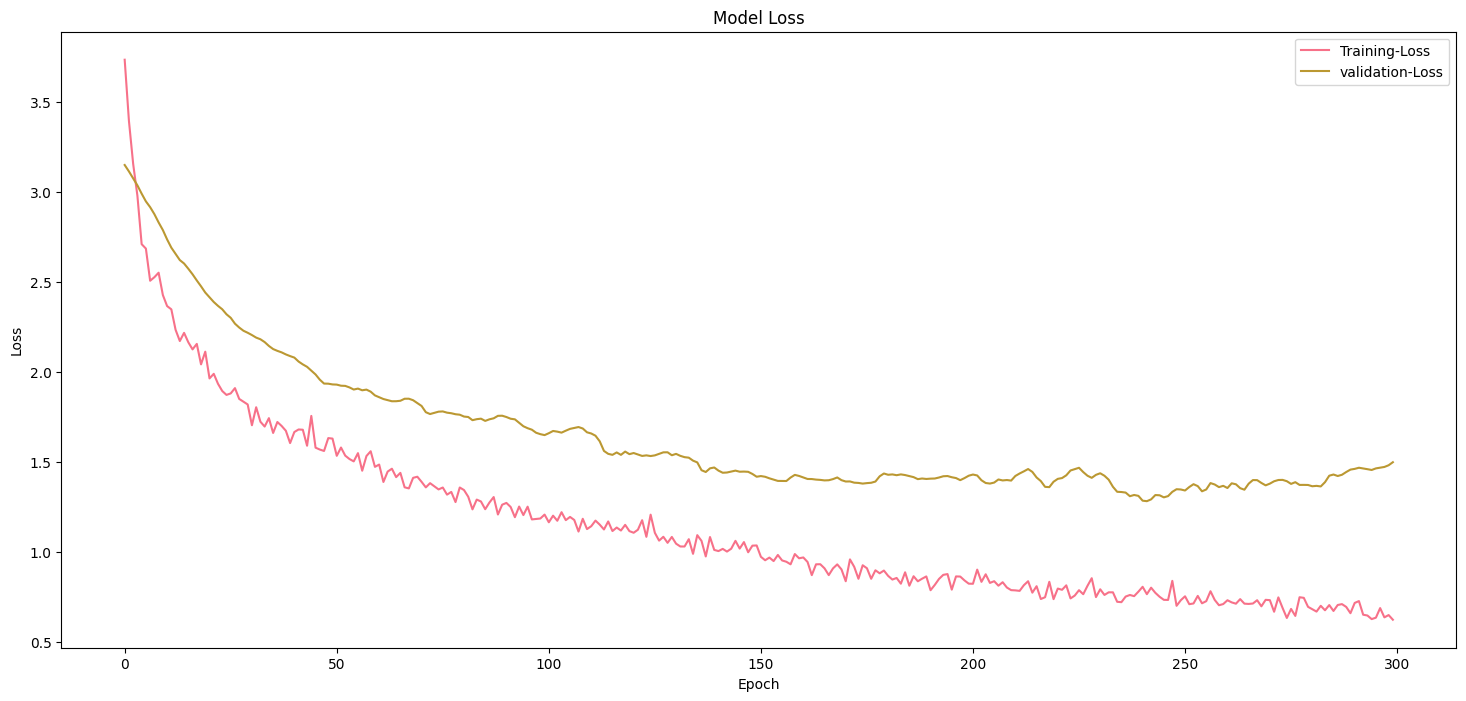

In [166]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training-Loss', 'validation-Loss'], loc='upper right')
plt.show()

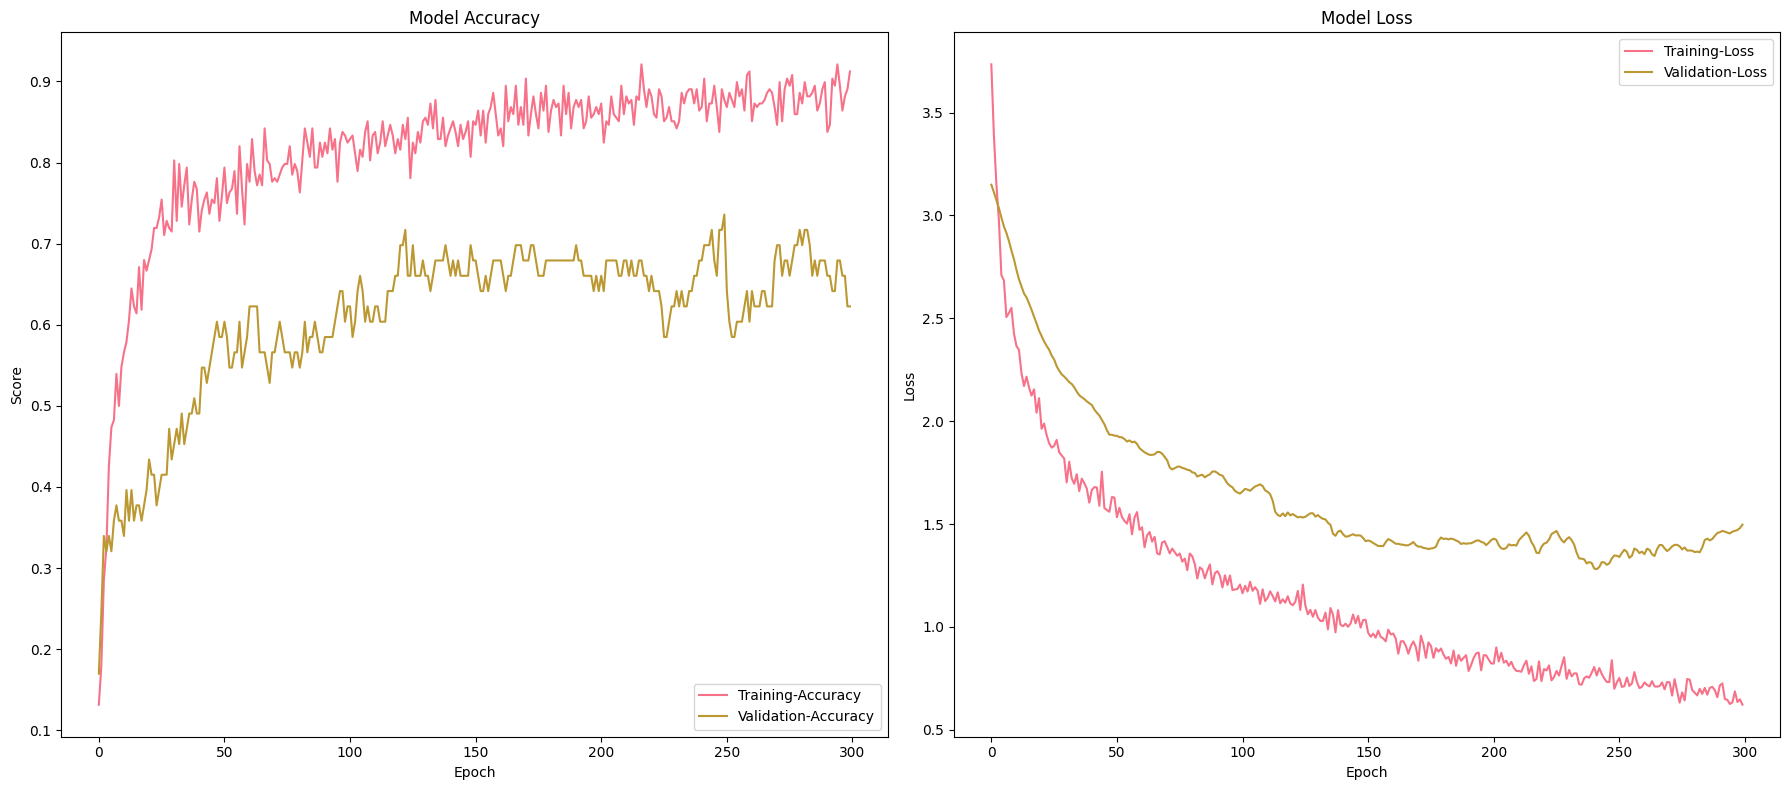

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ---- Accuracy Plot ----
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training-Accuracy', 'Validation-Accuracy'], loc='lower right')

# ---- Loss Plot ----
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training-Loss', 'Validation-Loss'], loc='upper right')

plt.tight_layout()
plt.show()

**F1-Score Per Class**

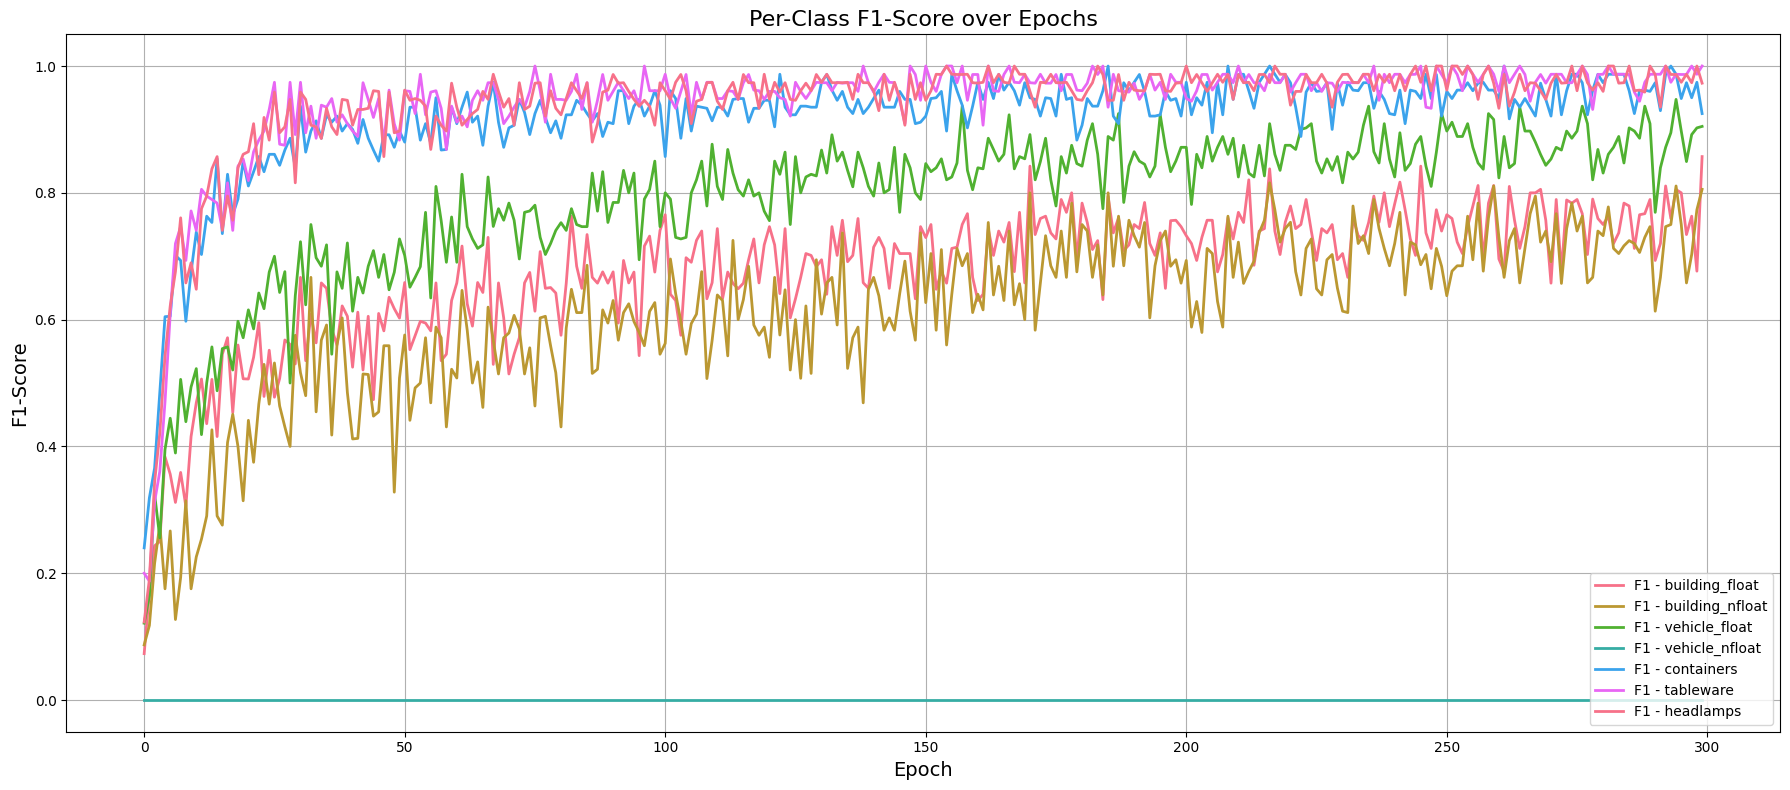

In [168]:
import numpy as np
import matplotlib.pyplot as plt

f1_array = np.array(history.history['f1_score']) 

class_names = []

for i in range(1, 8):
    class_names.append(index_to_label[i])

plt.figure(figsize=(18, 8))
for i in range(f1_array.shape[1]):
    plt.plot(f1_array[:, i], label=f'F1 - {class_names[i]}', linewidth=2)

plt.title('Per-Class F1-Score over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusion**

In [169]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5968 - f1_score: 0.5254 - loss: 1.5996


[1.5455271005630493,
 0.6296296119689941,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.6829268 , 0.5142857 , 0.44444442, 0.        , 0.79999995,
        0.79999995, 0.7692307 ], dtype=float32)>]

In [170]:
y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred,axis=1) + 1
y_test_max = np.argmax(y_test,axis=1) + 1

print(classification_report(y_test_max, y_pred_max))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
              precision    recall  f1-score   support

           1       0.61      0.78      0.68        18
           2       0.56      0.47      0.51        19
           3       0.40      0.50      0.44         4
           5       1.00      0.67      0.80         3
           6       0.67      1.00      0.80         2
           7       1.00      0.62      0.77         8

    accuracy                           0.63        54
   macro avg       0.71      0.67      0.67        54
weighted avg       0.66      0.63      0.63        54



**Confusion Matrix**

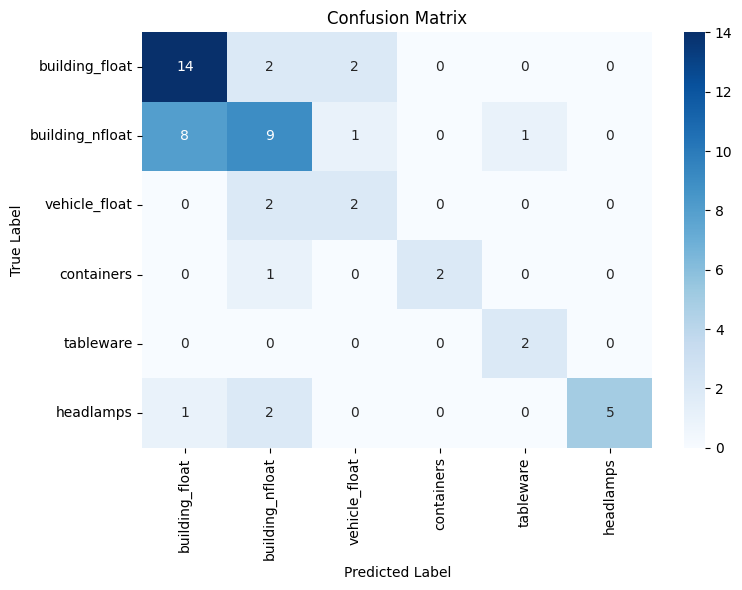

In [171]:
cm = confusion_matrix(y_test_max, y_pred_max)

# class_names = [str(i) for i in np.unique(y_test_max)]
class_names = [index_to_label[i] for i in np.unique(y_test_max)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**Save results**

In [176]:
nn_accuracy = accuracy_score(y_test_max, y_pred_max)
nn_f1 = f1_score(y_test_max, y_pred_max, average='macro')
nn_precision = precision_score(y_test_max, y_pred_max, average='macro')
nn_recall = recall_score(y_test_max, y_pred_max, average='macro')

model_results['Neural Network'] = {
    'accuracy': nn_accuracy,
    'f1_macro': nn_f1,
    'precision': nn_precision,
    'recall': nn_recall
}

In [177]:
for name, result in model_results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}, F1 Macro = {result['f1_macro']:.4f}, "
          f"Precision = {result['precision']:.4f}, Recall = {result['recall']:.4f}")

Logistic L2: Accuracy = 0.5882, F1 Macro = 0.6885, Precision = 0.7145, Recall = 0.7554
Logistic L1: Accuracy = 0.5882, F1 Macro = 0.6885, Precision = 0.7145, Recall = 0.7554
ElasticNet: Accuracy = 0.5882, F1 Macro = 0.6638, Precision = 0.6649, Recall = 0.7549
Random Forest: Accuracy = 0.8605, F1 Macro = 0.8324, Precision = 0.8448, Recall = 0.8429
SVM: Accuracy = 0.7407, F1 Macro = 0.6664, Precision = 0.8133, Recall = 0.6258
KNN: Accuracy = 0.8519, F1 Macro = 0.8079, Precision = 0.8861, Recall = 0.8181
XGBoost: Accuracy = 0.8372, F1 Macro = 0.8249, Precision = 0.7827, Recall = 0.9040
Neural Network: Accuracy = 0.6296, F1 Macro = 0.6685, Precision = 0.7063, Recall = 0.6739


**Comments**
- As the data is small, using neural network without sufficient settings will easily lead to overfitting.

## VI) Model Comparison and Analysis

In [180]:
# Create comparison DataFrame
comparison_df = pd.DataFrame.from_dict(model_results, orient='index')
comparison_df = comparison_df.round(4)

print("Model Performance Comparison:")
print("=" * 60)
print(comparison_df.to_string())

Model Performance Comparison:
                accuracy  f1_macro  precision  recall
Logistic L2       0.5882    0.6885     0.7145  0.7554
Logistic L1       0.5882    0.6885     0.7145  0.7554
ElasticNet        0.5882    0.6638     0.6649  0.7549
Random Forest     0.8605    0.8324     0.8448  0.8429
SVM               0.7407    0.6664     0.8133  0.6258
KNN               0.8519    0.8079     0.8861  0.8181
XGBoost           0.8372    0.8249     0.7827  0.9040
Neural Network    0.6296    0.6685     0.7063  0.6739


### All metrics comparison

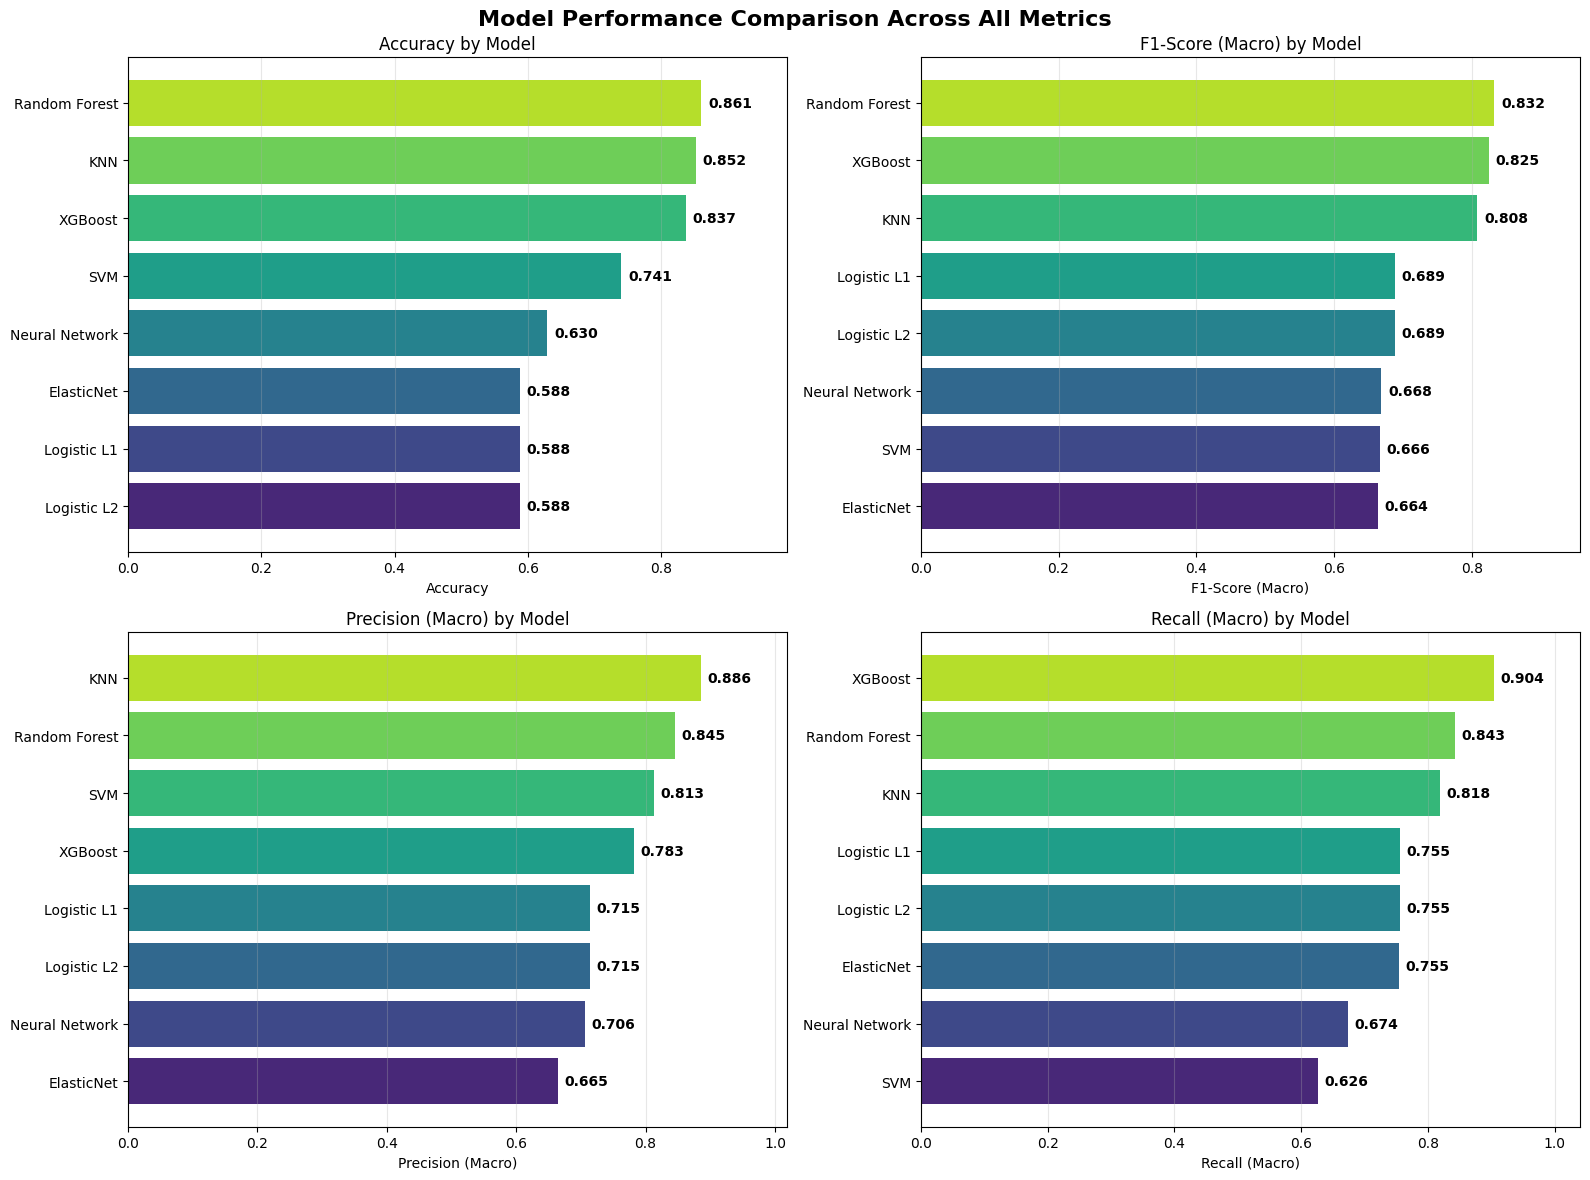

In [181]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# 1. Overall Performance Comparison Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'f1_macro', 'precision', 'recall']
metric_names = ['Accuracy', 'F1-Score (Macro)', 'Precision (Macro)', 'Recall (Macro)']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    
    # Sort models by performance for this metric
    sorted_data = comparison_df[metric].sort_values(ascending=True)
    
    # Create horizontal bar plot
    bars = ax.barh(range(len(sorted_data)), sorted_data.values, 
                   color=sns.color_palette("viridis", len(sorted_data)))
    
    # Customize the plot
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data.index)
    ax.set_xlabel(name)
    ax.set_title(f'{name} by Model')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (model, value) in enumerate(sorted_data.items()):
        ax.text(value + 0.01, i, f'{value:.3f}', 
                va='center', fontweight='bold')
    
    # Set x-axis limits
    ax.set_xlim(0, max(sorted_data.values) * 1.15)

plt.tight_layout()
plt.show()

### Radar Chart

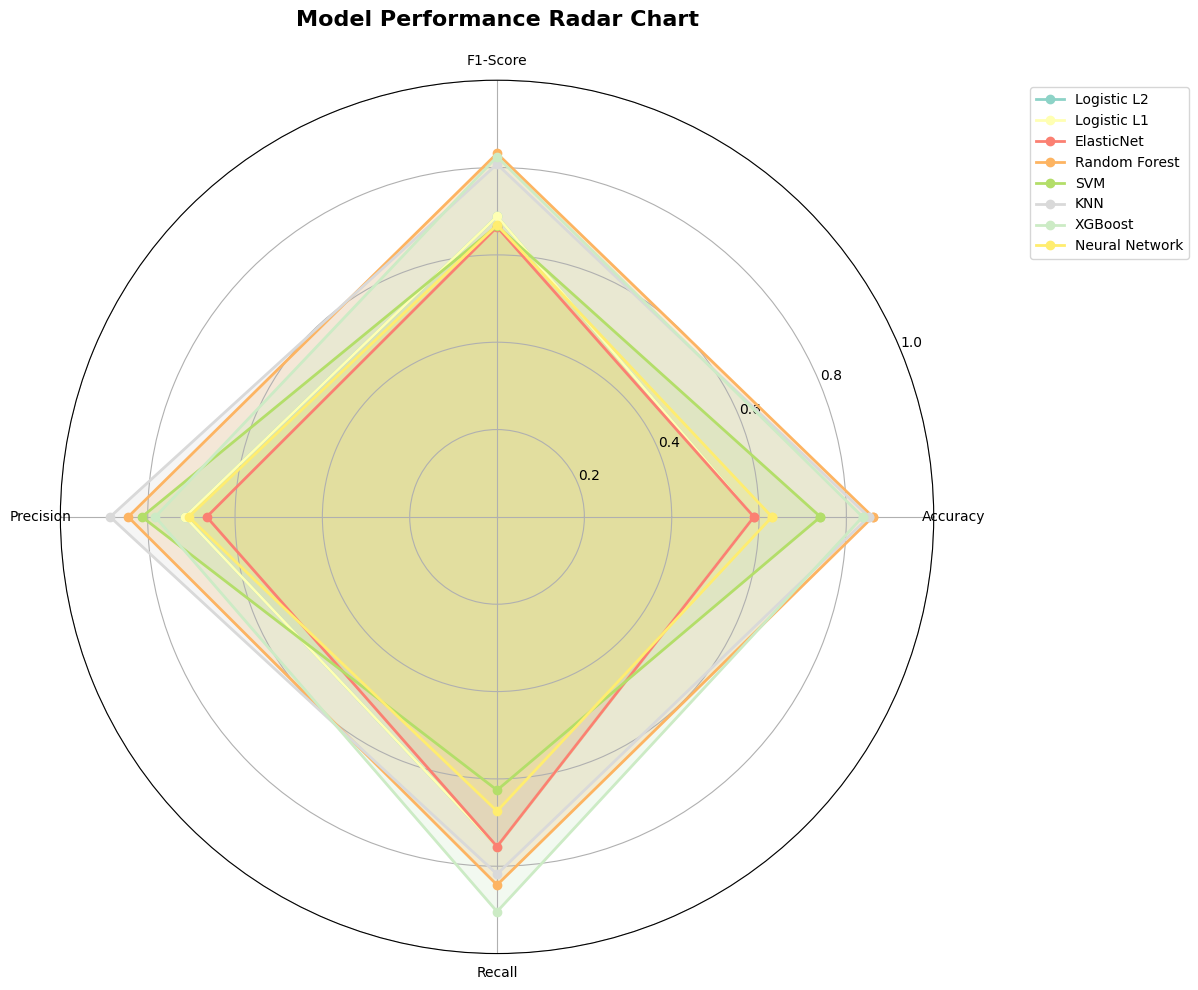

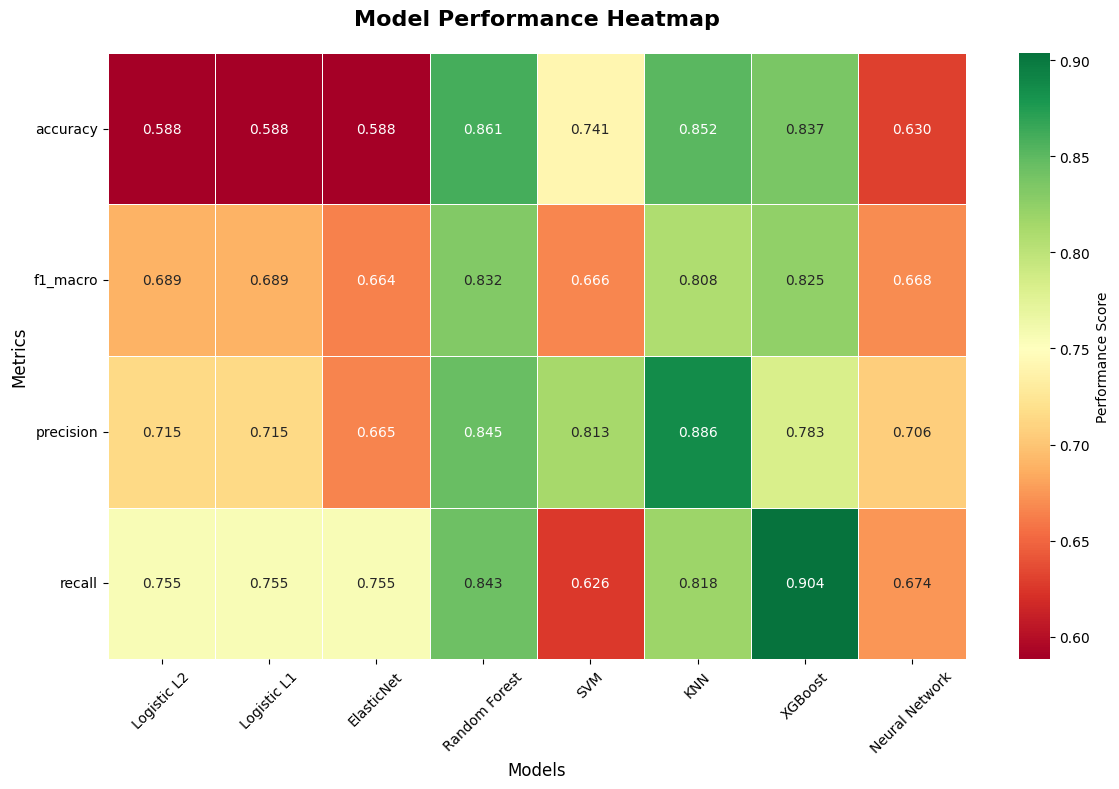

In [182]:
# 2. Radar Chart for Model Comparison
import math

def create_radar_chart(data_df, title="Model Performance Radar Chart"):
    """Create a radar chart comparing all models across all metrics"""
    
    # Number of metrics
    num_metrics = len(data_df.columns)
    
    # Calculate angle for each metric
    angles = [n / float(num_metrics) * 2 * math.pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the circle
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
    
    # Colors for each model
    colors = plt.cm.Set3(np.linspace(0, 1, len(data_df)))
    
    # Plot each model
    for idx, (model_name, row) in enumerate(data_df.iterrows()):
        values = row.values.tolist()
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Accuracy', 'F1-Score', 'Precision', 'Recall'])
    
    # Set y-axis limits and labels
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.grid(True)
    
    # Add title and legend
    plt.title(title, size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    plt.show()

# Create radar chart
create_radar_chart(comparison_df)

# 3. Heatmap of Model Performance
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(comparison_df.T, annot=True, cmap='RdYlGn', center=0.75, 
            fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Performance Score'})

plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Model Rankings

Model Rankings (1 = Best):
                Accuracy Rank  F1 Rank  Precision Rank  Recall Rank  Overall Rank
Random Forest             1.0      1.0             2.0          2.0           1.0
KNN                       2.0      3.0             1.0          3.0           2.0
XGBoost                   3.0      2.0             4.0          1.0           3.0
Logistic L2               6.0      4.0             5.0          4.0           4.0
Logistic L1               6.0      4.0             5.0          4.0           4.0
SVM                       4.0      7.0             3.0          8.0           6.0
Neural Network            5.0      6.0             7.0          7.0           7.0
ElasticNet                6.0      8.0             8.0          6.0           8.0


<Figure size 1200x800 with 0 Axes>

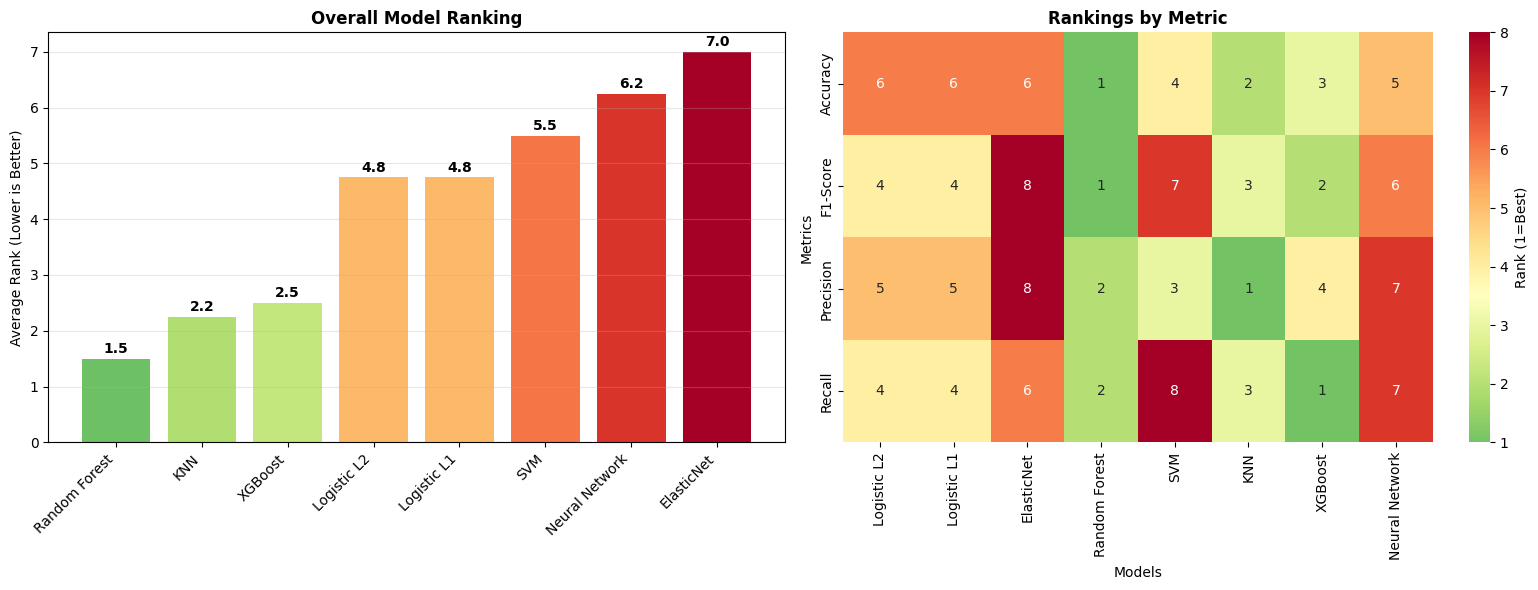

In [183]:
# 4. Model Ranking Analysis
def calculate_rankings(df):
    """Calculate rankings for each metric and overall ranking"""
    rankings = pd.DataFrame(index=df.index)
    
    # Calculate rank for each metric (1 = best)
    for metric in df.columns:
        rankings[f'{metric}_rank'] = df[metric].rank(ascending=False, method='min')
    
    # Calculate average ranking
    ranking_cols = [col for col in rankings.columns if col.endswith('_rank')]
    rankings['avg_rank'] = rankings[ranking_cols].mean(axis=1)
    rankings['overall_rank'] = rankings['avg_rank'].rank(method='min')
    
    return rankings

# Calculate rankings
model_rankings = calculate_rankings(comparison_df)

# Display ranking results
print("Model Rankings (1 = Best):")
print("=" * 50)
ranking_display = model_rankings[['accuracy_rank', 'f1_macro_rank', 'precision_rank', 'recall_rank', 'overall_rank']]
ranking_display.columns = ['Accuracy Rank', 'F1 Rank', 'Precision Rank', 'Recall Rank', 'Overall Rank']
print(ranking_display.sort_values('Overall Rank').to_string())

# 5. Overall Ranking Visualization
plt.figure(figsize=(12, 8))

# Sort by overall ranking
sorted_rankings = model_rankings.sort_values('overall_rank')

# Create subplot for overall ranking
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Overall ranking bar plot
bars1 = ax1.bar(range(len(sorted_rankings)), sorted_rankings['avg_rank'], 
               color=plt.cm.RdYlGn_r(sorted_rankings['avg_rank']/sorted_rankings['avg_rank'].max()))
ax1.set_xticks(range(len(sorted_rankings)))
ax1.set_xticklabels(sorted_rankings.index, rotation=45, ha='right')
ax1.set_ylabel('Average Rank (Lower is Better)')
ax1.set_title('Overall Model Ranking', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (model, rank) in enumerate(zip(sorted_rankings.index, sorted_rankings['avg_rank'])):
    ax1.text(i, rank + 0.1, f'{rank:.1f}', ha='center', fontweight='bold')

# Ranking by metric heatmap
ranking_matrix = model_rankings[['accuracy_rank', 'f1_macro_rank', 'precision_rank', 'recall_rank']].T
ranking_matrix.columns.name = 'Models'
ranking_matrix.index = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

sns.heatmap(ranking_matrix, annot=True, cmap='RdYlGn_r', center=3.5, 
            fmt='.0f', ax=ax2, cbar_kws={'label': 'Rank (1=Best)'})
ax2.set_title('Rankings by Metric', fontweight='bold')
ax2.set_xlabel('Models')
ax2.set_ylabel('Metrics')

plt.tight_layout()
plt.show()

### Model Analysis


Model Complexity vs Performance:
                accuracy  f1_macro  precision  recall complexity interpretability training_time
Logistic L2       0.5882    0.6885     0.7145  0.7554        Low             High          Fast
Logistic L1       0.5882    0.6885     0.7145  0.7554        Low             High          Fast
ElasticNet        0.5882    0.6638     0.6649  0.7549        Low             High          Fast
Random Forest     0.8605    0.8324     0.8448  0.8429     Medium           Medium        Medium
SVM               0.7407    0.6664     0.8133  0.6258     Medium              Low        Medium
KNN               0.8519    0.8079     0.8861  0.8181        Low           Medium          Fast
XGBoost           0.8372    0.8249     0.7827  0.9040       High              Low          Slow
Neural Network    0.6296    0.6685     0.7063  0.6739       High              Low          Slow


C:\Users\USER\AppData\Local\Temp\ipykernel_10896\3426401695.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].annotate(model, (x_complexity[i], y_accuracy[i]),
C:\Users\USER\AppData\Local\Temp\ipykernel_10896\3426401695.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].annotate(model, (x_complexity[i], y_f1[i]),


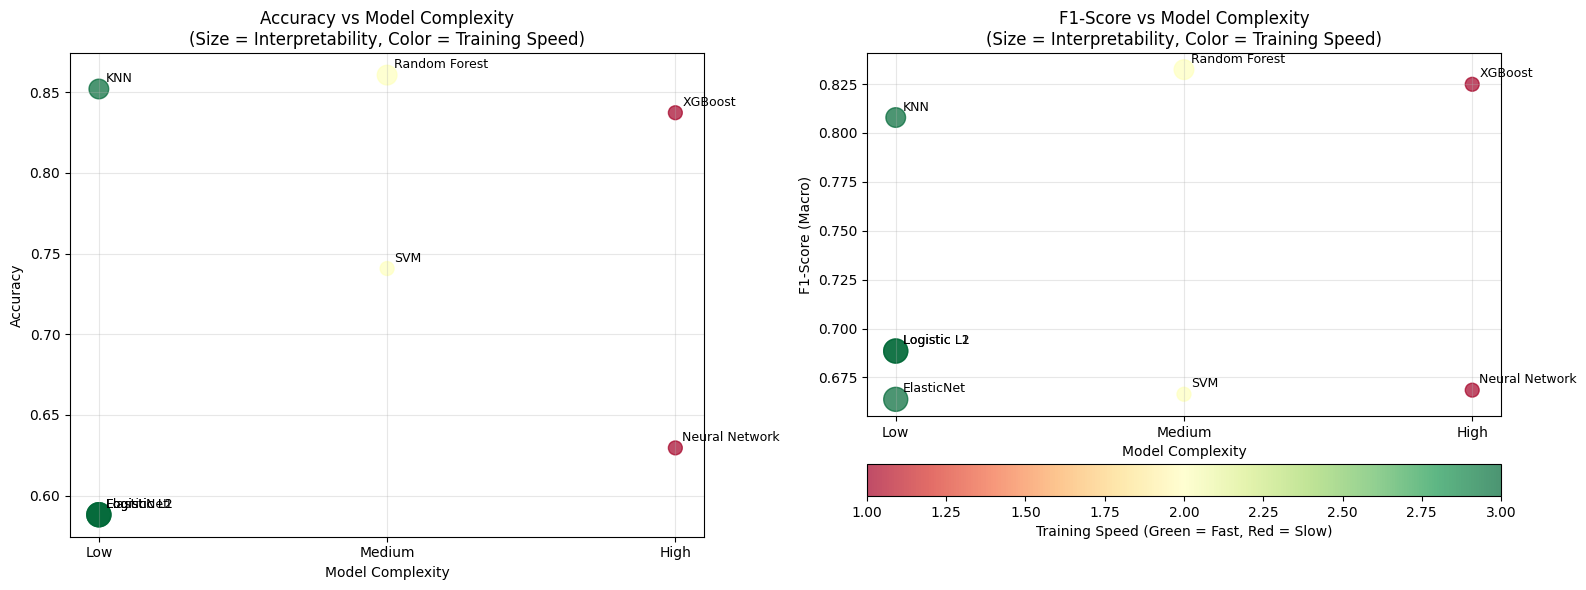

In [188]:
# 6. Model Complexity vs Performance Analysis
model_complexity = {
    'Logistic L1': {'complexity': 'Low', 'interpretability': 'High', 'training_time': 'Fast'},
    'Logistic L2': {'complexity': 'Low', 'interpretability': 'High', 'training_time': 'Fast'},
    'ElasticNet': {'complexity': 'Low', 'interpretability': 'High', 'training_time': 'Fast'},
    'Random Forest': {'complexity': 'Medium', 'interpretability': 'Medium', 'training_time': 'Medium'},
    'SVM': {'complexity': 'Medium', 'interpretability': 'Low', 'training_time': 'Medium'},
    'KNN': {'complexity': 'Low', 'interpretability': 'Medium', 'training_time': 'Fast'},
    'XGBoost': {'complexity': 'High', 'interpretability': 'Low', 'training_time': 'Slow'},
    'Neural Network': {'complexity': 'High', 'interpretability': 'Low', 'training_time': 'Slow'}
}

complexity_df = pd.DataFrame.from_dict(model_complexity, orient='index')

# Merge with performance data
final_comparison = pd.concat([comparison_df, complexity_df], axis=1)

print("\nModel Complexity vs Performance:")
print(final_comparison.to_string())

# 7. Performance vs Complexity Scatter Plot
complexity_numeric = {'Low': 1, 'Medium': 2, 'High': 3}
interpretability_numeric = {'High': 3, 'Medium': 2, 'Low': 1}
speed_numeric = {'Fast': 3, 'Medium': 2, 'Slow': 1}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy vs Complexity
x_complexity = [complexity_numeric[x] for x in final_comparison['complexity']]
y_accuracy = final_comparison['accuracy']

scatter1 = axes[0].scatter(x_complexity, y_accuracy, 
                          s=[interpretability_numeric[x]*100 for x in final_comparison['interpretability']], 
                          c=[speed_numeric[x] for x in final_comparison['training_time']], 
                          cmap='RdYlGn', alpha=0.7)

axes[0].set_xlabel('Model Complexity')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Model Complexity\n(Size = Interpretability, Color = Training Speed)')
axes[0].set_xticks([1, 2, 3])
axes[0].set_xticklabels(['Low', 'Medium', 'High'])
axes[0].grid(True, alpha=0.3)

# Add model names as annotations
for i, model in enumerate(final_comparison.index):
    axes[0].annotate(model, (x_complexity[i], y_accuracy[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# F1 vs Complexity
y_f1 = final_comparison['f1_macro']

scatter2 = axes[1].scatter(x_complexity, y_f1, 
                          s=[interpretability_numeric[x]*100 for x in final_comparison['interpretability']], 
                          c=[speed_numeric[x] for x in final_comparison['training_time']], 
                          cmap='RdYlGn', alpha=0.7)

axes[1].set_xlabel('Model Complexity')
axes[1].set_ylabel('F1-Score (Macro)')
axes[1].set_title('F1-Score vs Model Complexity\n(Size = Interpretability, Color = Training Speed)')
axes[1].set_xticks([1, 2, 3])
axes[1].set_xticklabels(['Low', 'Medium', 'High'])
axes[1].grid(True, alpha=0.3)

# Add model names as annotations
for i, model in enumerate(final_comparison.index):
    axes[1].annotate(model, (x_complexity[i], y_f1[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add colorbar
cbar = plt.colorbar(scatter2, ax=axes[1], orientation='horizontal', pad=0.1)
cbar.set_label('Training Speed (Green = Fast, Red = Slow)')

plt.tight_layout()
plt.show()

### Top K Model

In [189]:
# 8. Best and Worst Performing Models Analysis
print("TOP 3 MODELS BY EACH METRIC:")
print("=" * 50)

for metric in ['accuracy', 'f1_macro', 'precision', 'recall']:
    top_3 = comparison_df[metric].nlargest(3)
    print(f"\n{metric.upper().replace('_', ' ')}:")
    for rank, (model, score) in enumerate(top_3.items(), 1):
        print(f"  {rank}. {model}: {score:.4f}")

# 9. Model Recommendation Matrix
def get_recommendation_score(accuracy, f1, interpretability, speed, complexity):
    """Calculate recommendation score based on different criteria"""
    
    # Normalize scores
    performance_score = (accuracy + f1) / 2
    
    # Interpretability bonus
    interp_bonus = {'High': 0.05, 'Medium': 0.02, 'Low': 0}[interpretability]
    
    # Speed bonus
    speed_bonus = {'Fast': 0.03, 'Medium': 0.01, 'Slow': 0}[speed]
    
    # Complexity penalty (simpler is better for small datasets)
    complexity_penalty = {'Low': 0, 'Medium': -0.01, 'High': -0.02}[complexity]
    
    total_score = performance_score + interp_bonus + speed_bonus + complexity_penalty
    
    return total_score

# Calculate recommendation scores
recommendation_scores = []
for model in final_comparison.index:
    score = get_recommendation_score(
        final_comparison.loc[model, 'accuracy'],
        final_comparison.loc[model, 'f1_macro'],
        final_comparison.loc[model, 'interpretability'],
        final_comparison.loc[model, 'training_time'],
        final_comparison.loc[model, 'complexity']
    )
    recommendation_scores.append(score)

final_comparison['recommendation_score'] = recommendation_scores

recommended_models = final_comparison.sort_values(
    by='recommendation_score',
    ascending=False
)

# Assign unique ranks sequentially (1..n)
recommended_models['recommendation_rank'] = range(1, len(recommended_models) + 1)

final_comparison['recommendation_rank'] = recommended_models['recommendation_rank']

TOP 3 MODELS BY EACH METRIC:

ACCURACY:
  1. Random Forest: 0.8605
  2. KNN: 0.8519
  3. XGBoost: 0.8372

F1 MACRO:
  1. Random Forest: 0.8324
  2. XGBoost: 0.8249
  3. KNN: 0.8079

PRECISION:
  1. KNN: 0.8861
  2. Random Forest: 0.8448
  3. SVM: 0.8133

RECALL:
  1. XGBoost: 0.9040
  2. Random Forest: 0.8429
  3. KNN: 0.8181


### Model Selection Guide

C:\Users\USER\AppData\Local\Temp\ipykernel_10896\3493731159.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(model, (x[i], y[i]), xytext=(-30, -25), textcoords='offset points',


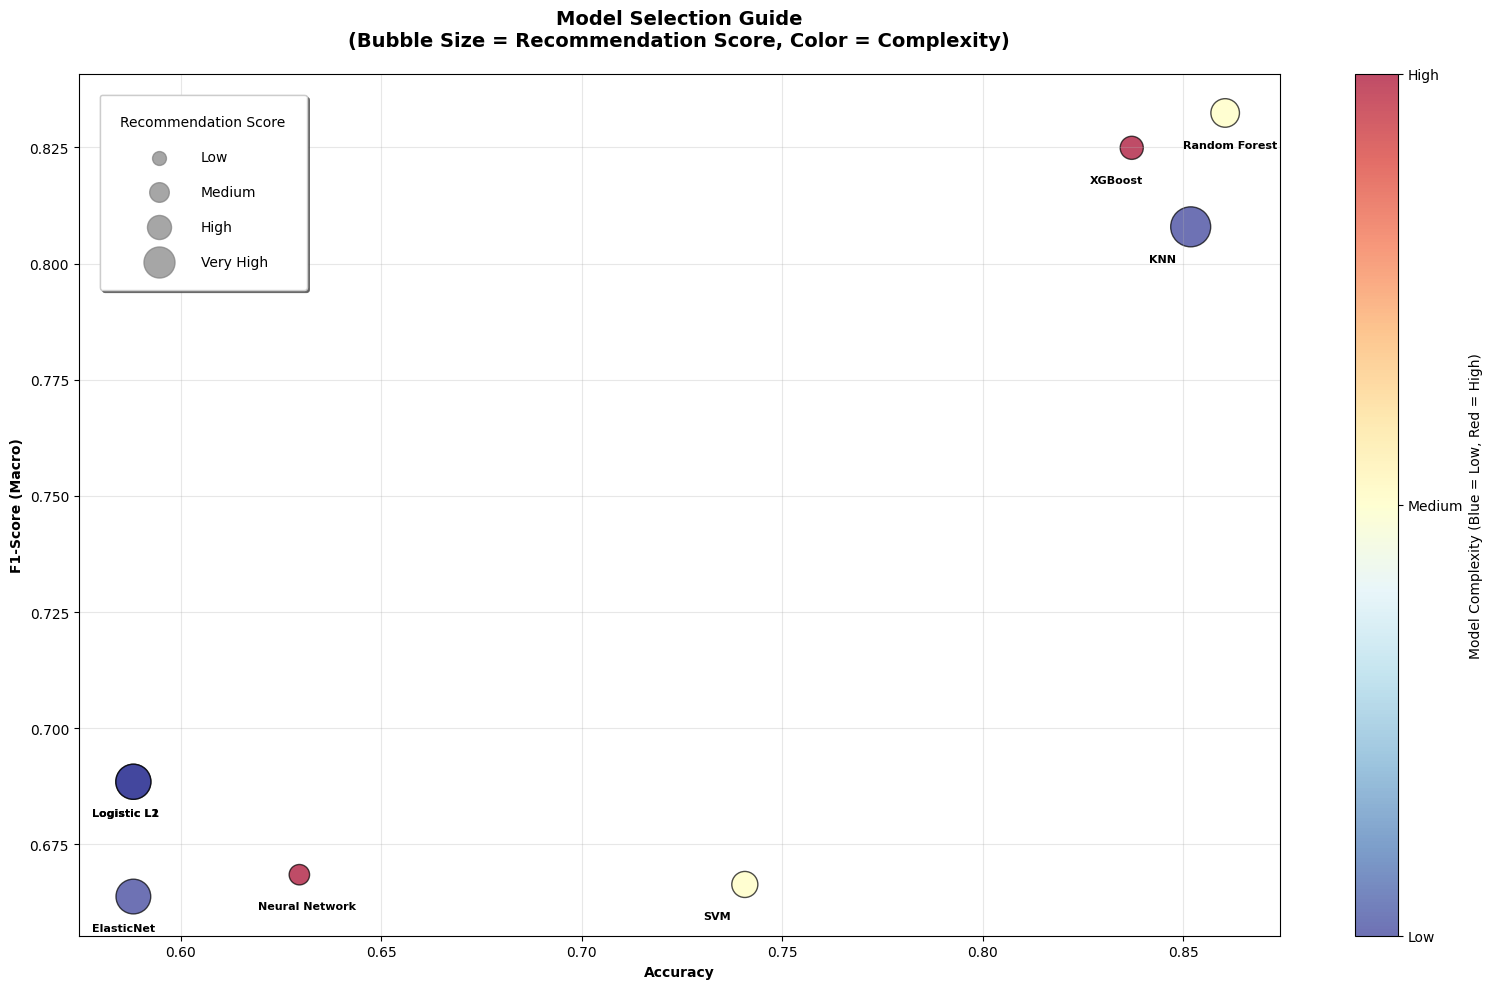

In [198]:
# 10. Final Visualization: Model Selection Guide
fig, ax = plt.subplots(figsize=(16, 10))

# Create recommendation score from accuracy, f1, and complexity
final_comparison['recommendation_score'] = (
    0.5 * final_comparison['accuracy'] +
    0.5 * final_comparison['f1_macro']
) / final_comparison['complexity'].map({'Low':1, 'Medium':2, 'High':3})


# Create bubble chart
models = final_comparison.index
x = final_comparison['accuracy']
y = final_comparison['f1_macro']
sizes = final_comparison['recommendation_score'] * 1000
colors = [complexity_numeric[comp] for comp in final_comparison['complexity']]

scatter = ax.scatter(x, y, s=sizes, c=colors, cmap='RdYlBu_r', alpha=0.7, edgecolors='black', linewidth=1)

# Add model labels
for i, model in enumerate(models):
    ax.annotate(model, (x[i], y[i]), xytext=(-30, -25), textcoords='offset points', 
                fontsize=8, fontweight='bold')

# Customize plot
ax.set_xlabel('Accuracy', fontsize=10, fontweight='bold')
ax.set_ylabel('F1-Score (Macro)', fontsize=10, fontweight='bold')
ax.set_title('Model Selection Guide\n(Bubble Size = Recommendation Score, Color = Complexity)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

# Add colorbar for complexity
cbar = plt.colorbar(scatter)
cbar.set_label('Model Complexity (Blue = Low, Red = High)', fontsize=10)
cbar.set_ticks([1, 2, 3])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

# Add legend for bubble sizes
handles, labels = ax.get_legend_handles_labels()
size_legend = [plt.scatter([], [], s=size, c='gray', alpha=0.7) 
               for size in [100, 200, 300, 500]]
size_labels = ['Low', 'Medium', 'High', 'Very High']
legend1 = ax.legend(size_legend, size_labels, scatterpoints=1, loc='upper left', 
                    title='Recommendation Score', 
                    frameon=True, 
                    fancybox=True, 
                    shadow=True, 
                    borderpad=1.5,      
                    labelspacing=1.5,    
                    handletextpad=1.5,    
                    borderaxespad=1.5,    
                    handlelength=3.0)
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

### Summary Table

In [192]:
# 12. Create Final Summary Table
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 100)

# Create comprehensive summary
summary_table = pd.DataFrame({
    'Model': final_comparison.index,
    'Accuracy': final_comparison['accuracy'].round(4),
    'F1-Score': final_comparison['f1_macro'].round(4),
    'Precision': final_comparison['precision'].round(4),
    'Recall': final_comparison['recall'].round(4),
    'Complexity': final_comparison['complexity'],
    'Interpretability': final_comparison['interpretability'],
    'Training Speed': final_comparison['training_time'],
    'Overall Rank': final_comparison['recommendation_rank'].astype(int),
}).sort_values('Overall Rank')

print(summary_table.to_string(index=False))

# 13. Export Results to CSV (optional)
try:
    summary_table.to_csv('model_comparison_results.csv', index=False)
    print(f"\n✅ Results exported to 'model_comparison_results.csv'")
except:
    print(f"\n❌ Could not export to CSV")


print(f"\n{'='*60}")
print("💡 KEY TAKEAWAYS:")
print(f"{'='*60}")
print("• KNN achieved the highest overall rank with strong precision and fast training")
print("• Random Forest offers the best balance between performance, interpretability, and training speed")
print("• XGBoost provides high recall but is less interpretable and slow to train on small datasets")
print("• Logistic Regression (L1 & L2) provides high interpretability and is a reliable baseline model")
print("• Neural Network underperformed due to overfitting and limited data size")
print("• SVM showed lower recall, likely affected by class imbalance")
print("• Outlier removal had mixed effects — beneficial for some models but reduced performance for others")
print("• Feature engineering (e.g., power transformation) improved performance across most models")
print("• Class imbalance remains a challenge — SMOTE helped, but more data is needed")

FINAL MODEL COMPARISON SUMMARY
         Model  Accuracy  F1-Score  Precision  Recall Complexity Interpretability Training Speed  Overall Rank
           KNN    0.8519    0.8079     0.8861  0.8181        Low           Medium           Fast             1
 Random Forest    0.8605    0.8324     0.8448  0.8429     Medium           Medium         Medium             2
       XGBoost    0.8372    0.8249     0.7827  0.9040       High              Low           Slow             3
   Logistic L2    0.5882    0.6885     0.7145  0.7554        Low             High           Fast             4
   Logistic L1    0.5882    0.6885     0.7145  0.7554        Low             High           Fast             5
    ElasticNet    0.5882    0.6638     0.6649  0.7549        Low             High           Fast             6
           SVM    0.7407    0.6664     0.8133  0.6258     Medium              Low         Medium             7
Neural Network    0.6296    0.6685     0.7063  0.6739       High              Low

## VII) Conclusion

### **Best Performing Models**
1. **K-Nearest Neighbors (KNN)** – Achieved the highest overall ranking with strong accuracy (85.2%) and excellent precision (88.6%)  
2. **Random Forest** – Consistently high across all metrics, including accuracy (86.1%) and F1-score (83.2%)  
3. **XGBoost** – High recall (90.4%) but lower interpretability and slow training speed  

---

### **Performance Insights**
- **KNN** delivered the best overall performance with a strong balance of metrics and fast training time  
- **Random Forest** ranked second, offering excellent trade-offs between performance, interpretability, and training speed  
- **XGBoost** showed strong recall but required longer training and had low interpretability  
- **SVM** had relatively low F1-score, likely due to sensitivity to class imbalance  
- **Neural Network** underperformed due to small dataset size and overfitting risk  
- **Outlier removal** had mixed effects — improved recall for ElasticNet, but reduced performance for Logistic Regression  

---

### **Model Selection Recommendations**

**For Production Use**  
- **Random Forest**: Best overall choice with strong performance, moderate interpretability, and good handling of imbalanced data  

**For Interpretability**  
- **Logistic Regression (L1 & L2)**: High interpretability, fast training, and decent baseline performance  

**For Quick Prototyping**  
- **KNN**: Fast training and strong performance without the need for extensive tuning  

---

### **Avoid**
- **Neural Network**: Prone to overfitting and performed poorly on small datasets  
- **SVM**: Did not handle class imbalance well in this scenario  

---

### **Technical Considerations**
- **Data Size**: Small dataset (214 samples) favors simpler models like KNN and Logistic Regression  
- **Class Imbalance**: Significantly affected performance; SMOTE helped but more data is needed  
- **Feature Engineering**: Power transformation improved performance across all models  
- **Outlier Removal**: Had limited impact overall, but slightly benefited some models like ElasticNet  